In [1]:
import tensorflow as tf
import datetime, os
#hide tf logs 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # or any {'0', '1', '2'} 
#0 (default) shows all, 1 to filter out INFO logs, 2 to additionally filter out WARNING logs, and 3 to additionally filter out ERROR logs
import scipy.optimize
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import time
from pyDOE import lhs         #Latin Hypercube Sampling
import seaborn as sns 
import codecs, json
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error 

# generates same random numbers each time
np.random.seed(1233)
tf.random.set_seed(1233)

print("TensorFlow version: {}".format(tf.__version__))

TensorFlow version: 2.9.1


# *Data Prep*

Training and Testing data is prepared from the solution file

In [2]:
## Data Import
K_real = np.load('./K_tx_real_d_one.npy') # Values of K(t,x)
Q_real = np.load('./Q_15minutes.npy') # Input Matrix of Model
f_real = Q_real[:,1] # Inflow Rate
v_real = Q_real[:,3] # Average Speed
pi_real = np.load('./pitilde_15minutes.npy') # Values of pi(t,x)

In [3]:
pi_real.shape

(150, 2016)

Text(0, 0.5, 'Remaining Trip Distance (miles)')

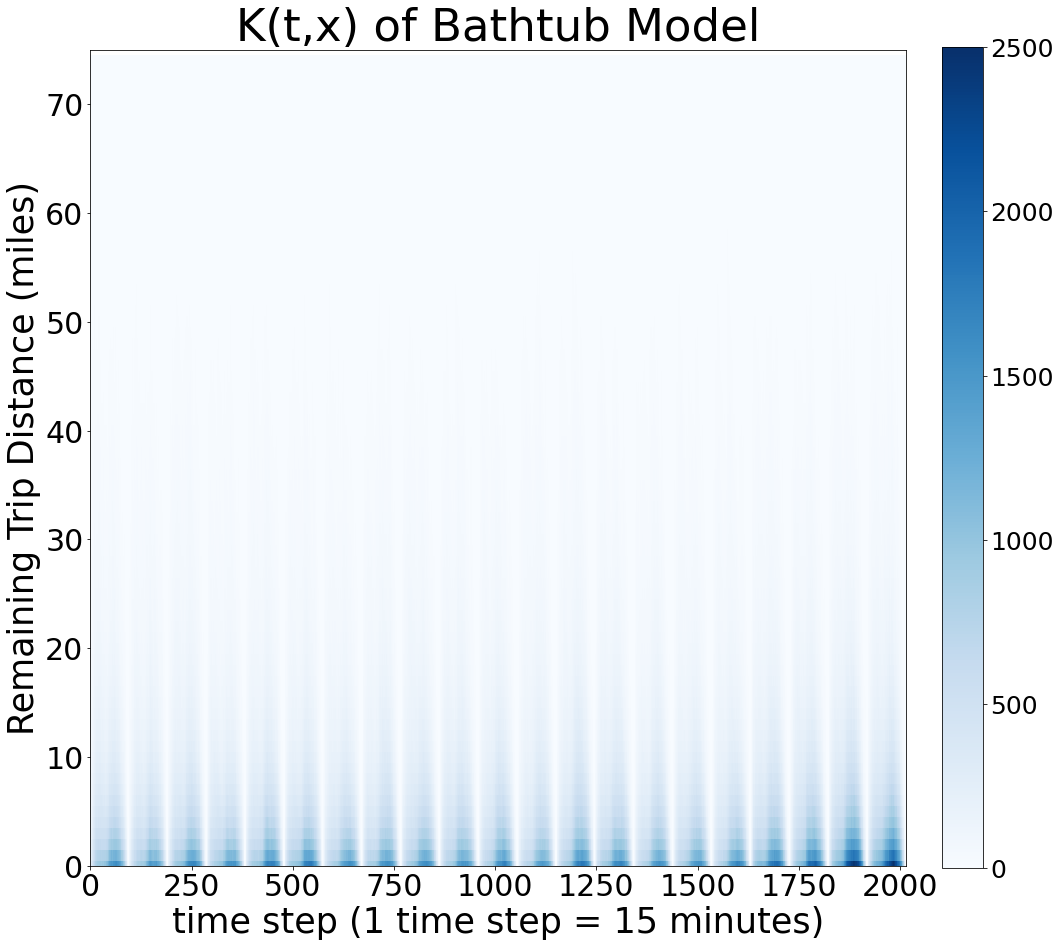

In [4]:
K_array = np.array(K_real[:,0:len(K_real[0])])
fig, ax = plt.subplots(figsize=(16, 16))
plt.rcParams['font.size'] = '25'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(30)
plt.imshow(K_array.T, cmap = 'Blues', interpolation='nearest')
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis([0,2016,0,len(K_real[0])])
plt.clim(0, 2500) 
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.title('K(t,x) of Bathtub Model', fontsize=45)
plt.xlabel('time step (1 time step = 15 minutes)', fontsize=35)
plt.ylabel('Remaining Trip Distance (miles)', fontsize=35)

In [5]:
## Scale
N_timestep = 24*21*4 # 24 hours * 21 days * 15 minutes = total timestep
N_diststep = 75 # 1 distance step = 1 mile
Size_diststep = 1 # unit: miles
N_trainingdays = 0 # Set zero (0)
N_training = 24*4*N_trainingdays # Training data is all


## Normalization [0,1]
x = np.arange(0,int(N_diststep/Size_diststep))[:,None]   # x: step of remaining distance
t = np.arange(0,N_timestep)[:,None]    # Time step 
usol = K_real.transpose() [:,N_training:]     # real value of K(t,x) ==> Target Variable
usol_max = usol.max()

## Normalization [0,1]
x = (x - x.min()) / (x.max() - x.min())
t = (t - t.min()) / (t.max() - t.min())
f_real = (f_real - usol.min()) / (usol.max() - usol.min())  # usol과 같은 dimension이어야 함. 단위 같기 때문.
v_real = (v_real - v_real.min()) / (v_real.max() - v_real.min())
usol = (usol - usol.min()) / (usol.max()-usol.min())

X, T = np.meshgrid(x,t)                     # makes 2 arrays X and T such that u(X[i],T[j])=usol[i][j] are a tuple


multiplier_dist = int(N_diststep/Size_diststep)-1
multiplier_time = N_timestep-1
multiplier_u = usol_max
print('multiplier distance = ', multiplier_dist)
print('multiplier time = ', multiplier_time)
print('usol max = ', usol_max)

multiplier distance =  74
multiplier time =  2015
usol max =  2500


In [6]:
Size_diststep = 25 # unit: miles
size_input = int(N_diststep/Size_diststep)*N_timestep # Total number of grid points
# size_input = int(N_diststep/Size_diststep)*2 + N_timestep*7 # Boundary
N_u = int(size_input*0.2) # Total number of data points for 'u' ==> Training data from grid points
N_f = N_u*2 #Total number of collocation (auxiliary) points 
alpha = 0.5 # weights of loss

print('size input = ', size_input)
print('N_u = ', N_u)
print('N_f = ', N_f)

size input =  6048
N_u =  1209
N_f =  2418


In [7]:
# # Previous version (before Aug 30)
# size_input = int(N_diststep/Size_diststep)*N_timestep # All domain
# # size_input = int(N_diststep/Size_diststep)*2 + N_timestep*7 # Boundary
# N_u = int(size_input*0.5) #Total number of data points for 'u'
# N_f = N_u*2 #Total number of collocation points 
# alpha = 0.5

# print('size input = ', size_input)
# print('N_u = ', N_u)
# print('N_f = ', N_f)

# *Grid Data*

We prepare the grid data to compare against the solution produced by the PINN.

In [8]:
''' X_u_test = [X[i],T[i]] [25600,2] for interpolation'''
X_u_grid = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))

# Domain bounds
lb = X_u_grid[0]  # [-1. 0.]
ub = X_u_grid[-1] # [1.  0.99]

'''
   Fortran Style ('F') flatten,stacked column wise!
   u = [c1 
        c2
        .
        .
        cn]

   u =  [25600x1] 
'''
u_grid = usol.flatten('F')[:,None] 

# *Training Data* (All domain)


The boundary conditions serve as the test data for the PINN and the collocation points are generated using **Latin Hypercube Sampling**

In [9]:
def trainingdata(N_u,N_f):

#     '''Boundary Conditions'''

#     #Initial Condition 0 =< x =< 9 (135 miles) and t = 0  
#     leftedge_x = np.hstack((X[0,:][:,None], T[0,:][:,None])) #L1
#     leftedge_u = usol[:,0][:,None]
    
#     #Initial Condition 0 =< x =< 9 (135 miles) and t = 2015  
#     rightedge_x = np.hstack((X[0,:][:,None], T[-1,:][:,None])) #L1
#     rightedge_u = usol[:,-1][:,None]

#     #Boundary Condition x = 9 (135 miles) and 0 =< t =<2015
#     topedge_x = np.hstack((X[:,-1][:,None], T[:,0][:,None])) #L3
#     topedge_u = usol[-1,:][:,None]
        
#     #Boundary Condition x = 0 and 0 =< t =<2015
#     bottomedge_x = np.hstack((X[:,0][:,None], T[:,0][:,None])) #L2
#     bottomedge_u = usol[0,:][:,None]
    
#     #Boundary Condition x = 5 (25 miles) and 0 =< t =<2015
#     midedge_x = np.hstack((X[:,5][:,None], T[:,0][:,None])) #L3
#     midedge_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 10 (50 miles) and 0 =< t =<2015
#     midedge1_x = np.hstack((X[:,10][:,None], T[:,0][:,None])) #L3
#     midedge1_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 15 (75 miles) and 0 =< t =<2015
#     midedge2_x = np.hstack((X[:,15][:,None], T[:,0][:,None])) #L3
#     midedge2_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 20 (100 miles) and 0 =< t =<2015
#     midedge3_x = np.hstack((X[:,20][:,None], T[:,0][:,None])) #L3
#     midedge3_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 25 (125 miles) and 0 =< t =<2015
#     midedge4_x = np.hstack((X[:,25][:,None], T[:,0][:,None])) #L3
#     midedge4_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 2 and 0 =< t =<2015
#     bottomedge_x_2 = np.hstack((X[:,1][:,None], T[:,0][:,None])) #L2
#     bottomedge_u_2 = usol[2,:][:,None]
    
#     #Boundary Condition x = 1 and 0 =< t =<2015
#     bottomedge_x_1 = np.hstack((X[:,1][:,None], T[:,0][:,None])) #L2
#     bottomedge_u_1 = usol[1,:][:,None]


#     all_X_u_train = np.vstack([leftedge_x, rightedge_x, bottomedge_x, topedge_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([leftedge_u, rightedge_u, bottomedge_u, topedge_u])   #corresponding u [4042,]

#     all_X_u_train = np.vstack([leftedge_x, rightedge_x, bottomedge_x, topedge_x, midedge_x, midedge1_x, midedge2_x, midedge3_x, midedge4_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([leftedge_u, rightedge_u, bottomedge_u, topedge_u, midedge_u, midedge1_u, midedge2_u, midedge3_u, midedge4_u])   #corresponding u [4042,]

#     all_X_u_train = np.vstack([leftedge_x, rightedge_x, bottomedge_x, topedge_x, midedge_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([leftedge_u, rightedge_u, bottomedge_u, topedge_u, midedge_u])   #corresponding u [4042,]

#     all_X_u_train = np.vstack([bottomedge_x, bottomedge_x_1, bottomedge_x_2]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([bottomedge_u, bottomedge_u_1, bottomedge_u_2])   #corresponding u [4042,]
    
#     all_X_u_train = np.vstack([bottomedge_x, topedge_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([bottomedge_u, topedge_u])   #corresponding u [4042,]

    all_X_u_train = np.hstack((X.T[range(0,N_diststep,Size_diststep)].flatten()[:,None],T.T[range(0,N_diststep,Size_diststep)].flatten()[:,None]))
    all_u_train = usol[range(0,N_diststep,Size_diststep)].flatten()[:,None]
    
    #choose random N_u points for training
    np.random.seed(1233)
    train_idx = np.random.choice(all_X_u_train.shape[0], N_u, replace=False) # ID of training data
    test_idx = np.delete(np.arange(size_input), train_idx) # ID of testing data
    
    # Training Data
    X_u_train = all_X_u_train[train_idx, :] #choose indices from  set 'idx' (x,t)
    u_train = all_u_train[train_idx,:]      #choose corresponding u
    
    # Testing Data
    X_u_test = all_X_u_train[test_idx, :]
    u_test = all_u_train[test_idx,:]

    '''Collocation Points'''

    # Latin Hypercube sampling for collocation points 
    # N_f sets of tuples(x,t)
#     X_f_train = np.rint(lb + (ub-lb)*lhs(2,N_f))
    X_f_train = (lb + (ub-lb)*lhs(2,N_f))
#     X_f_train = np.unique(X_f_train, axis=0).astype(int) # 중복된 것 없앰
    X_f_train = np.vstack((X_f_train, X_u_train)) # append training points to collocation points 
    
    f_t = f_real[np.int0(X_f_train*multiplier_time)[:,1]][:,None]
    pi_tx = pi_real[np.int0(X_f_train*multiplier_dist)[:,0],np.int0(X_f_train*multiplier_time)[:,1]][:,None]
    v_t = v_real[np.int0(X_f_train*multiplier_time)[:,1]][:,None]

    return X_f_train, X_u_train, u_train, X_u_test, u_test, f_t, pi_tx, v_t, all_X_u_train, all_u_train, train_idx, test_idx

In [10]:
X_f_train, X_u_train, u_train, X_u_test, u_test, f_t, pi_tx, v_t, all_X_u_train, all_u_train, train_idx, test_idx  = trainingdata(N_u,N_f)

In [11]:
X_u_train.shape

(1209, 2)

In [12]:
X_u_test.shape

(4839, 2)

In [13]:
X_u_train

array([[0.33783784, 0.92903226],
       [0.        , 0.95235732],
       [0.33783784, 0.89181141],
       ...,
       [0.        , 0.69330025],
       [0.33783784, 0.6764268 ],
       [0.67567568, 0.3235732 ]])

# **PINN**

Generate a **PINN** of L hidden layers, each with n neurons. 

Initialization: ***Xavier***

Activation: *tanh (x)*

In [14]:
class Sequentialmodel(tf.Module): 
    def __init__(self, layers, name=None):
       
        self.W = []  #Weights and biases
        self.parameters = 0 #total number of parameters
        
        for i in range(len(layers)-1):
            
            input_dim = layers[i]
            output_dim = layers[i+1]
            
            #Xavier standard deviation 
            std_dv = np.sqrt((2.0/(input_dim + output_dim)))

            #weights = normal distribution * Xavier standard deviation + 0
            w = tf.random.normal([input_dim, output_dim], dtype = 'float64') * std_dv
                       
            w = tf.Variable(w, trainable=True, name = 'w' + str(i+1))

            b = tf.Variable(tf.cast(tf.zeros([output_dim]), dtype = 'float64'), trainable = True, name = 'b' + str(i+1))
                    
            self.W.append(w)
            self.W.append(b)
            
            self.parameters +=  input_dim * output_dim + output_dim
    
    def evaluate(self,x):
        
        x = (x-lb)/(ub-lb)
        
        a = x
        
        for i in range(len(layers)-2):
            
            z = tf.add(tf.matmul(a, self.W[2*i]), self.W[2*i+1])
            a = tf.nn.tanh(z)
            
        a = tf.add(tf.matmul(a, self.W[-2]), self.W[-1]) # For regression, no activation to last layer
        return a
    
#     def speed(self,x):
        
#         a = tf.math.minimum(u_free, tf.abs(a_speed/x + b_speed))

#         print('speed = ', a)
#         print('k = ', x)

#         return a
    
    def get_weights(self):

        parameters_1d = []  # [.... W_i,b_i.....  ] 1d array
        
        for i in range (len(layers)-1):
            
            w_1d = tf.reshape(self.W[2*i],[-1])   #flatten weights 
            b_1d = tf.reshape(self.W[2*i+1],[-1]) #flatten biases
            
            parameters_1d = tf.concat([parameters_1d, w_1d], 0) #concat weights 
            parameters_1d = tf.concat([parameters_1d, b_1d], 0) #concat biases
        
        return parameters_1d
        
    def set_weights(self,parameters):
                
        for i in range (len(layers)-1):

            shape_w = tf.shape(self.W[2*i]).numpy() # shape of the weight tensor
            size_w = tf.size(self.W[2*i]).numpy() #size of the weight tensor 
            
            shape_b = tf.shape(self.W[2*i+1]).numpy() # shape of the bias tensor
            size_b = tf.size(self.W[2*i+1]).numpy() #size of the bias tensor 
                        
            pick_w = parameters[0:size_w] #pick the weights 
            self.W[2*i].assign(tf.reshape(pick_w,shape_w)) # assign  
            parameters = np.delete(parameters,np.arange(size_w),0) #delete 
            
            pick_b = parameters[0:size_b] #pick the biases 
            self.W[2*i+1].assign(tf.reshape(pick_b,shape_b)) # assign 
            parameters = np.delete(parameters,np.arange(size_b),0) #delete 

            
    def loss_BC(self,x,y):

        loss_u = tf.reduce_mean(tf.square(y-self.evaluate(x)))
        return loss_u
    
    def loss(self,x,y):

        loss_u = self.loss_BC(x,y)

        loss = loss_u

        return loss, loss_u
    
    def optimizerfunc(self,parameters):
        
        self.set_weights(parameters)
       
        with tf.GradientTape() as tape:
            tape.watch(self.trainable_variables)
            
            loss_val, loss_u= self.loss(X_u_train, u_train)
            
        grads = tape.gradient(loss_val,self.trainable_variables)
                
        del tape
        
        grads_1d = [ ] #flatten grads 
        
        for i in range (len(layers)-1):

            grads_w_1d = tf.reshape(grads[2*i],[-1]) #flatten weights 
            grads_b_1d = tf.reshape(grads[2*i+1],[-1]) #flatten biases

            grads_1d = tf.concat([grads_1d, grads_w_1d], 0) #concat grad_weights 
            grads_1d = tf.concat([grads_1d, grads_b_1d], 0) #concat grad_biases

        return loss_val.numpy(), grads_1d.numpy()
    
    def optimizer_callback(self,parameters):
               
        loss_value, loss_u = self.loss(X_u_train, u_train)
        
        u_pred = self.evaluate(X_u_test)
        error_vec = np.linalg.norm((u_test-u_pred),2)/np.linalg.norm(u_test,2)
        loss_record.append(loss_value)
        l2_record.append(error_vec)
        
        tf.print(loss_value, loss_u, error_vec)

# *Model Training and Testing*

A function '**model**' is defined to generate a NN as per the input set of hyperparameters, which is then trained and tested. The L2 Norm of the solution error is returned as a comparison metric

In [15]:
# Training data
X_f_train, X_u_train, u_train, X_u_test, u_test, f_t, pi_tx, v_t, all_X_u_train, all_u_train, train_idx, test_idx  = trainingdata(N_u,N_f)
#alpha = int(N_f/N_u) #weight of loss function

layers = np.array([2,20,20,20,20,20,20,20,20,1]) #8 hidden layers
loss_record = []
l2_record = []

PINN = Sequentialmodel(layers)

init_params = PINN.get_weights().numpy()

start_time = time.time() 

# train the model with Scipy L-BFGS optimizer
results = scipy.optimize.minimize(fun = PINN.optimizerfunc, 
                                  x0 = init_params, 
                                  args=(), 
                                  method='L-BFGS-B', 
                                  jac= True,        # If jac is True, fun is assumed to return the gradient along with the objective function
                                  callback = PINN.optimizer_callback, 
                                  options = {'disp': None,
                                            'maxcor': 100, 
                                            'ftol': 1 * np.finfo(float).eps,  #The iteration stops when (f^k - f^{k+1})/max{|f^k|,|f^{k+1}|,1} <= ftol
#                                             'ftol': 1e-10,  #The iteration stops when (f^k - f^{k+1})/max{|f^k|,|f^{k+1}|,1} <= ftol
                                            'gtol': 1e-10, 
                                            'maxfun':  50000, 
                                            'maxiter': 15000,
                                            'iprint': -1,   #print update every 50 iterations
                                            'maxls': 50})
end_time = time.time()

0.045439165892428343 0.045439165892428343 0.7745329799461859
0.039008249516874156 0.039008249516874156 0.7168435237458167
0.02414240820908849 0.02414240820908849 0.5629060529717513
0.023341314713857853 0.023341314713857853 0.5555819102952049
0.022751580230496827 0.022751580230496827 0.5480627552683933
0.022702654577801365 0.022702654577801365 0.5474607029689512
0.022657855612223613 0.022657855612223613 0.5471466979663997
0.022486969683298118 0.022486969683298118 0.5463666736767845
0.022335370010779967 0.022335370010779967 0.545525123197358
0.021875889367968877 0.021875889367968877 0.5421637965278551
0.021340163400250925 0.021340163400250925 0.5363954754792862
0.019679605851391939 0.019679605851391939 0.5147148398090918
0.019408797765869925 0.019408797765869925 0.5107386699360886
0.019151809281806965 0.019151809281806965 0.5071256151022051
0.018668353153459445 0.018668353153459445 0.4976861066280269
0.018332285378721419 0.018332285378721419 0.49347131545948586
0.018130931358697238 0.018

0.012506010849394964 0.012506010849394964 0.4292315919149169
0.012505805529822216 0.012505805529822216 0.42928443978597214
0.012505633810891273 0.012505633810891273 0.42933916610030143
0.012505430579069592 0.012505430579069592 0.42920375204388467
0.012505366955136007 0.012505366955136007 0.4292249677286881
0.012505311410275225 0.012505311410275225 0.4292105536276352
0.012505304577738383 0.012505304577738383 0.42922887024755096
0.012505282863057791 0.012505282863057791 0.4292115973881702
0.012505257635376375 0.012505257635376375 0.4292001035843269
0.012505211386919476 0.012505211386919476 0.4291896763234597
0.012505135297687518 0.012505135297687518 0.4291975199240563
0.012505028076303297 0.012505028076303297 0.42919781904015775
0.012504780011366073 0.012504780011366073 0.42917533916228445
0.012504629834834512 0.012504629834834512 0.4291978126975953
0.012504189743840349 0.012504189743840349 0.4292104652556525
0.012503342728459627 0.012503342728459627 0.4291725805573359
0.0125031664262220

0.012474092085713128 0.012474092085713128 0.428687705976638
0.012473940006111378 0.012473940006111378 0.42868567293518395
0.012473823204520911 0.012473823204520911 0.42868045043852854
0.012473652003866841 0.012473652003866841 0.4286934252946788
0.012473541747272842 0.012473541747272842 0.4287154167978872
0.012473388417992842 0.012473388417992842 0.42874011554743807
0.012473266902375286 0.012473266902375286 0.428749109977587
0.012473162284062606 0.012473162284062606 0.4287553769625267
0.012473106035342083 0.012473106035342083 0.42878105597420163
0.012472940603343394 0.012472940603343394 0.4288253308155055
0.012472823776557628 0.012472823776557628 0.4287522632070224
0.012472735178913804 0.012472735178913804 0.42870115319113034
0.012472690541447857 0.012472690541447857 0.4287310877001638
0.012472674665591288 0.012472674665591288 0.4287475864117281
0.012472643349646038 0.012472643349646038 0.4287484731574761
0.012472557480920844 0.012472557480920844 0.4287487709946001
0.01247242791930289 0

0.012417276218540356 0.012417276218540356 0.42863926791715956
0.012416994714508325 0.012416994714508325 0.42854531220142067
0.012416342973029626 0.012416342973029626 0.4283521828185074
0.012416007505725607 0.012416007505725607 0.4283792879632122
0.01241562638303579 0.01241562638303579 0.4283945887759585
0.012415167865676776 0.012415167865676776 0.4284038851291945
0.012414917925219569 0.012414917925219569 0.4283347746113665
0.012414849360414718 0.012414849360414718 0.42841525189065033
0.012414846969579818 0.012414846969579818 0.42837182204754704
0.0124148326996908 0.0124148326996908 0.4283782229338228
0.01241482847256067 0.01241482847256067 0.4283916486427088
0.012414827877363767 0.012414827877363767 0.42838965942508084
0.012414827202312172 0.012414827202312172 0.42838829995309197
0.012414826044073693 0.012414826044073693 0.42838824360560107
0.012414822841992438 0.012414822841992438 0.4283874178002411
0.012414815072333357 0.012414815072333357 0.42838678469774544
0.012414795674524762 0.0

0.012369744495285207 0.012369744495285207 0.4290402356512483
0.012368829646151863 0.012368829646151863 0.4291443910773295
0.012368200663041869 0.012368200663041869 0.42910100773234855
0.012366842336609033 0.012366842336609033 0.4291234350171857
0.012366013937191377 0.012366013937191377 0.42933479396374125
0.012365598389835511 0.012365598389835511 0.42938007343914597
0.0123652602979473 0.0123652602979473 0.42927281712938486
0.012364998932832947 0.012364998932832947 0.4292294427340396
0.012364656770516371 0.012364656770516371 0.4292392678568471
0.012363916513742388 0.012363916513742388 0.42923900678067994
0.012363320228303351 0.012363320228303351 0.4291946403120973
0.0123615724432268 0.0123615724432268 0.42915451085812917
0.012361164757332673 0.012361164757332673 0.42936658581460213
0.012359853350323715 0.012359853350323715 0.42915346379646124
0.012359626928482172 0.012359626928482172 0.4292138062471145
0.012359249687368202 0.012359249687368202 0.4292884541850136
0.012359065628682255 0.0

0.012337429765311454 0.012337429765311454 0.42986598819669614
0.0123374158682829 0.0123374158682829 0.4298938822415797
0.012337389471544323 0.012337389471544323 0.42989562763084505
0.012337342325702549 0.012337342325702549 0.42987078100550086
0.012337275539748824 0.012337275539748824 0.4299044614676361
0.01233718764071756 0.01233718764071756 0.42993268214199715
0.012337117020466807 0.012337117020466807 0.42992383187847877
0.012336994298071738 0.012336994298071738 0.42995686784816095
0.012336716912365852 0.012336716912365852 0.42994645609313925
0.012336513302922772 0.012336513302922772 0.429813141105273
0.012336418721918206 0.012336418721918206 0.42973010530151856
0.012336246893264671 0.012336246893264671 0.4297636851838608
0.012336178111090472 0.012336178111090472 0.4297434534970398
0.012336125573581574 0.012336125573581574 0.4296906079099246
0.012336073534709249 0.012336073534709249 0.4296751165810572
0.01233602876307416 0.01233602876307416 0.42967954949330905
0.012335998615947528 0.0

0.012328469902595869 0.012328469902595869 0.4297102326235633
0.012328456870831095 0.012328456870831095 0.4297102836602202
0.012328452713482622 0.012328452713482622 0.42971065039840933
0.012328448528292178 0.012328448528292178 0.4297008286752444
0.012328438075205646 0.012328438075205646 0.4296939591253401
0.012328409533909507 0.012328409533909507 0.4296764218080145
0.012328375187123434 0.012328375187123434 0.4296664438656235
0.01232828670573563 0.01232828670573563 0.4296660863195158
0.012328220548320229 0.012328220548320229 0.42965586843602704
0.012328168078298618 0.012328168078298618 0.4296307806741884
0.012328118150389011 0.012328118150389011 0.4296332419873611
0.012328091224480647 0.012328091224480647 0.42964897800361374
0.012328046787937226 0.012328046787937226 0.4296517629792512
0.012327998892167616 0.012327998892167616 0.4296863422090185
0.012327964292387014 0.012327964292387014 0.42967887861246884
0.012327938584351425 0.012327938584351425 0.429702552002327
0.012327923825885968 0.

0.012320609002328396 0.012320609002328396 0.4295837655013189
0.012320586810458957 0.012320586810458957 0.42957066616043815
0.012320548937904073 0.012320548937904073 0.4295718686301579
0.012320492139988792 0.012320492139988792 0.4295477157765044
0.012320431301720116 0.012320431301720116 0.42958479174835856
0.012320383202403836 0.012320383202403836 0.4295382006440856
0.012320364124008032 0.012320364124008032 0.4295003451885554
0.01232034275671824 0.01232034275671824 0.42949676939330433
0.012320325717936391 0.012320325717936391 0.42948279105587633
0.012320312127490929 0.012320312127490929 0.42948134347427097
0.012320304112066112 0.012320304112066112 0.42946171265317484
0.012320292311298326 0.012320292311298326 0.4294739136640785
0.012320282390289577 0.012320282390289577 0.42944892072552904
0.012320274363847378 0.012320274363847378 0.4294810332559686
0.012320271511220915 0.012320271511220915 0.4294699431876779
0.012320269143865741 0.012320269143865741 0.42946678816253364
0.0123202669330789

0.01231673174504439 0.01231673174504439 0.4295601766714245
0.012316708731334643 0.012316708731334643 0.4295424385667912
0.012316674498577875 0.012316674498577875 0.4295250331405336
0.012316624564940374 0.012316624564940374 0.4295163723822402
0.012316538041245197 0.012316538041245197 0.42951798026606114
0.0123165081107344 0.0123165081107344 0.42951251951076497
0.012316493137079446 0.012316493137079446 0.42951305740285245
0.012316461321125877 0.012316461321125877 0.429510449004872
0.012316436321756238 0.012316436321756238 0.4295206858259602
0.012316412714090983 0.012316412714090983 0.42946336346392217
0.012316402114745611 0.012316402114745611 0.4294915651992468
0.012316387891778271 0.012316387891778271 0.42950135792118044
0.012316377743372697 0.012316377743372697 0.4294578771920943
0.012316369733191945 0.012316369733191945 0.42949011863852254
0.012316362058014051 0.012316362058014051 0.4295175325235178
0.012316338922260538 0.012316338922260538 0.4294981424811642
0.012316328207528222 0.01

0.012311632017789188 0.012311632017789188 0.42919941308008147
0.012311631649692931 0.012311631649692931 0.42919764927808934
0.012311631295548795 0.012311631295548795 0.4291959208660289
0.012311630777717941 0.012311630777717941 0.42919590001468094
0.012311630500310781 0.012311630500310781 0.4291918083466438
0.01231162932363767 0.01231162932363767 0.42918932062928494
0.012311627235437614 0.012311627235437614 0.4291934749785465
0.012311625744839192 0.012311625744839192 0.4291881380237847
0.012311622627351845 0.012311622627351845 0.4291816744179193
0.012311612077987139 0.012311612077987139 0.42918318072909534
0.012311584708041142 0.012311584708041142 0.42920880262279654
0.012311577629612883 0.012311577629612883 0.42920246096160963
0.012311563845816683 0.012311563845816683 0.4291867023745886
0.012311536207777874 0.012311536207777874 0.4291704954077967
0.012311506438246441 0.012311506438246441 0.4291633652529406
0.012311493965952736 0.012311493965952736 0.42915772957879844
0.0123114913421622

0.012302642691020235 0.012302642691020235 0.42910549228882944
0.012302630543474949 0.012302630543474949 0.4291123154717115
0.012302600371124534 0.012302600371124534 0.4291372025268314
0.012302586473105821 0.012302586473105821 0.4291651960522121
0.012302574530875928 0.012302574530875928 0.4291616470525852
0.012302538528640786 0.012302538528640786 0.4291900717007964
0.012302525034977719 0.012302525034977719 0.42918534053729746
0.012302453880809269 0.012302453880809269 0.4291457975843209
0.012302383241334007 0.012302383241334007 0.4291544910996579
0.012302283696707005 0.012302283696707005 0.4291126402432818
0.012302221013095398 0.012302221013095398 0.42908406262759774
0.012302107494223023 0.012302107494223023 0.42909664626035177
0.012301992207463114 0.012301992207463114 0.4290937286075336
0.012301789187874604 0.012301789187874604 0.4290450033953815
0.012301741983938536 0.012301741983938536 0.42901439332588875
0.012301627657272638 0.012301627657272638 0.4289786833902946
0.01230152492716184

0.012295724353959531 0.012295724353959531 0.4287412710178862
0.012295616218468048 0.012295616218468048 0.42881421921191404
0.012295560975776767 0.012295560975776767 0.42890247175990837
0.012295511719614195 0.012295511719614195 0.42890432381990984
0.012295489747354791 0.012295489747354791 0.42890247862591
0.012295479934451051 0.012295479934451051 0.4289128551977753
0.012295460749783242 0.012295460749783242 0.42893132902639086
0.012295433555488967 0.012295433555488967 0.42894071726325683
0.012295410694691672 0.012295410694691672 0.42895796944012976
0.012295397511363654 0.012295397511363654 0.42896745459108737
0.01229538188825648 0.01229538188825648 0.4289914363883395
0.012295363707710444 0.012295363707710444 0.4290204312575493
0.012295336264754826 0.012295336264754826 0.42905701805744545
0.012295315553496337 0.012295315553496337 0.42907537451087907
0.012295286362585986 0.012295286362585986 0.4290774565853657
0.012295224180697515 0.012295224180697515 0.4290759402317415
0.01229514734164303

0.012267587317159136 0.012267587317159136 0.4297104295366814
0.012267033704824544 0.012267033704824544 0.42971737981017316
0.01226693102936019 0.01226693102936019 0.4296751429423422
0.012266760344485735 0.012266760344485735 0.4296551943896654
0.012266584190280195 0.012266584190280195 0.4296606336757272
0.012266526002526562 0.012266526002526562 0.42966351454171264
0.012266495538787383 0.012266495538787383 0.4296854245788049
0.012266476620732943 0.012266476620732943 0.42967159956608036
0.012266381881495009 0.012266381881495009 0.4296366991860927
0.012266225692063046 0.012266225692063046 0.4295760041098002
0.012265917846160948 0.012265917846160948 0.4295645793932464
0.01226551514570827 0.01226551514570827 0.4295187275205321
0.012264660014579026 0.012264660014579026 0.42947431212994785
0.012263949108020734 0.012263949108020734 0.4295467124350293
0.012262629279336607 0.012262629279336607 0.42993570106051343
0.012260820223375473 0.012260820223375473 0.42975165588236464
0.012260196379142276 0

0.0120891362179084 0.0120891362179084 0.426418731896318
0.01208847875438341 0.01208847875438341 0.42633758211836303
0.012087324308483119 0.012087324308483119 0.426179496706069
0.012085444258036305 0.012085444258036305 0.42618800491727143
0.0120851756330654 0.0120851756330654 0.42637816537332873
0.012082840048621639 0.012082840048621639 0.4260364595235051
0.012082310058243603 0.012082310058243603 0.42594528225312833
0.012081661806324058 0.012081661806324058 0.4260566563594319
0.012081181455770508 0.012081181455770508 0.42605050449260684
0.012081018790377472 0.012081018790377472 0.4261928355668226
0.01208013707626217 0.01208013707626217 0.42614098581422494
0.012079542527669086 0.012079542527669086 0.426070803441252
0.012078542629123626 0.012078542629123626 0.4261083921551345
0.012078062213507438 0.012078062213507438 0.4260477761715431
0.012077000036655475 0.012077000036655475 0.42593049142996864
0.012075922068843392 0.012075922068843392 0.42603744393288556
0.012074836190471097 0.01207483

0.012046611929657836 0.012046611929657836 0.4248636087286975
0.012046313456023042 0.012046313456023042 0.42480971740096163
0.012046113948768465 0.012046113948768465 0.4248195749588602
0.012045914453023375 0.012045914453023375 0.42483589903635277
0.012045668281416793 0.012045668281416793 0.42485417658153046
0.012045438927404978 0.012045438927404978 0.42483381665696723
0.012045191663165495 0.012045191663165495 0.42464210197989344
0.012044769826895549 0.012044769826895549 0.424745655077529
0.012044664837650517 0.012044664837650517 0.42484793461628895
0.012044411686812606 0.012044411686812606 0.42472786085442044
0.012044228319694126 0.012044228319694126 0.4247199272971444
0.012044048989872221 0.012044048989872221 0.42470477279721036
0.012043819217763792 0.012043819217763792 0.4246858425082563
0.012043418241410808 0.012043418241410808 0.42467321598106483
0.012043041708475906 0.012043041708475906 0.42456500956257714
0.01204275536583297 0.01204275536583297 0.42458935081446236
0.01204265871353

0.012031563729965408 0.012031563729965408 0.4249253781359607
0.012031529415766511 0.012031529415766511 0.4249119840994667
0.012031472444016235 0.012031472444016235 0.42489753926649126
0.012031469927410455 0.012031469927410455 0.4249177711687539
0.01203134019445677 0.01203134019445677 0.4249039016585628
0.012031333271890116 0.012031333271890116 0.4249404615475013
0.012031254165447373 0.012031254165447373 0.42492880439859393
0.012031209820927109 0.012031209820927109 0.4249253352338439
0.012031154394841989 0.012031154394841989 0.42493797339133255
0.012031114725607767 0.012031114725607767 0.4249393264136988
0.012031049798905329 0.012031049798905329 0.42495745856436545
0.012030983714546511 0.012030983714546511 0.42497314201840974
0.012030844440161205 0.012030844440161205 0.42496929038865927
0.012030768944603431 0.012030768944603431 0.42498315642195084
0.012030650693269669 0.012030650693269669 0.42496509564255286
0.012030598583642645 0.012030598583642645 0.4249483649885828
0.0120305472572146

0.012020142131167132 0.012020142131167132 0.42492470399597243
0.01202013247775398 0.01202013247775398 0.4249019829529325
0.01202008863486778 0.01202008863486778 0.42492842556565164
0.012020073215231606 0.012020073215231606 0.42489714332753786
0.012020040317358295 0.012020040317358295 0.4249113035190231
0.012019971738500654 0.012019971738500654 0.4249327636943142
0.012019921460798957 0.012019921460798957 0.4249024988643519
0.0120198681915047 0.0120198681915047 0.42488925840819236
0.012019787495207865 0.012019787495207865 0.42491017835250117
0.012019679432350723 0.012019679432350723 0.4249125944389396
0.012019580438604396 0.012019580438604396 0.42487940262522644
0.012019472653686017 0.012019472653686017 0.4248892309806695
0.012019341425122161 0.012019341425122161 0.4249119573517369
0.012019227234477625 0.012019227234477625 0.42492684828088456
0.012019077796003905 0.012019077796003905 0.42498997304689895
0.012018982659795278 0.012018982659795278 0.4248912292819086
0.012018876134945542 0.0

0.011987294604838888 0.011987294604838888 0.42363938678969276
0.011986955678216041 0.011986955678216041 0.42364248676492644
0.011986824953852258 0.011986824953852258 0.4237328805999644
0.011986588291597138 0.011986588291597138 0.4236495292864559
0.011986491882784625 0.011986491882784625 0.4236249749074175
0.011986405498062474 0.011986405498062474 0.4236165043016187
0.011986188963832191 0.011986188963832191 0.42363727184404365
0.011985993549188849 0.011985993549188849 0.42357758349457403
0.011985578360027152 0.011985578360027152 0.42355465893878
0.011985381060691136 0.011985381060691136 0.4235490270947191
0.011985137689040335 0.011985137689040335 0.42362483006054585
0.011984909680669261 0.011984909680669261 0.4234726004358833
0.011984689257327409 0.011984689257327409 0.42344956838315334
0.011984485451429784 0.011984485451429784 0.423476227527461
0.011984232483214901 0.011984232483214901 0.4234703410819372
0.011984000671595147 0.011984000671595147 0.4234407468274569
0.011983649993964866 

0.011861064179275476 0.011861064179275476 0.42000641209357553
0.011860667650973683 0.011860667650973683 0.420022057715157
0.011860270685200009 0.011860270685200009 0.4200789611915606
0.011860028596258312 0.011860028596258312 0.4202339155929638
0.011859674367369684 0.011859674367369684 0.4202395987768844
0.011859430849522507 0.011859430849522507 0.4201373625683941
0.011859085052225138 0.011859085052225138 0.42022500475908275
0.011858844992928027 0.011858844992928027 0.42021902237159886
0.011858668824715124 0.011858668824715124 0.420201584658268
0.011858421926753021 0.011858421926753021 0.4202818391494495
0.011858077874228381 0.011858077874228381 0.42035042754255036
0.011857652242292913 0.011857652242292913 0.42029973575826163
0.011857063598348476 0.011857063598348476 0.42020701690107404
0.011856184851400324 0.011856184851400324 0.420085827409457
0.011855976335238334 0.011855976335238334 0.42006550856000174
0.011855784485542928 0.011855784485542928 0.4202904436514487
0.011855457994440443

0.01182789916252236 0.01182789916252236 0.4196285922377925
0.011827805524000099 0.011827805524000099 0.41957745248242745
0.011827652167085138 0.011827652167085138 0.4196271568691561
0.011827470686008741 0.011827470686008741 0.41967457559123944
0.011827234655779666 0.011827234655779666 0.4196582686035981
0.011826912060999664 0.011826912060999664 0.4196515140006806
0.0118265114280618 0.0118265114280618 0.4196277202270424
0.011826234640942162 0.011826234640942162 0.41946024682666055
0.01182579918416141 0.01182579918416141 0.41953975453424097
0.01182543926855437 0.01182543926855437 0.4197029419536078
0.011825160995614396 0.011825160995614396 0.41968654450059634
0.011824556347374402 0.011824556347374402 0.4194451601241212
0.011824069055348227 0.011824069055348227 0.4194680586205186
0.011823348849603456 0.011823348849603456 0.4195475649706473
0.011822456294668299 0.011822456294668299 0.4195661017026157
0.011821538523606942 0.011821538523606942 0.4194940127085443
0.011820806760374057 0.011820

0.011782191691323565 0.011782191691323565 0.4195691831653955
0.011782171279099167 0.011782171279099167 0.4195926570894161
0.01178213439271316 0.01178213439271316 0.41962966003636615
0.011782092646988271 0.011782092646988271 0.4196455084393429
0.011782047414824652 0.011782047414824652 0.41963609517533046
0.011782022451460488 0.011782022451460488 0.4196138074819815
0.01178200640104125 0.01178200640104125 0.4196089946533298
0.011781978476007642 0.011781978476007642 0.41960385201360983
0.011781928767831441 0.011781928767831441 0.4196246322940655
0.0117817849584821 0.0117817849584821 0.4196015534498399
0.011781503971309372 0.011781503971309372 0.41949931825288067
0.011781344974524089 0.011781344974524089 0.41946984124149705
0.011781242557523122 0.011781242557523122 0.41942393802088174
0.011781060339709052 0.011781060339709052 0.4194206547279437
0.011780873992752555 0.011780873992752555 0.41935123531556706
0.011780665190380197 0.011780665190380197 0.41936851972890093
0.011780604455067329 0.0

0.011773029780460223 0.011773029780460223 0.4191918727676923
0.011772975817968561 0.011772975817968561 0.4191840369512521
0.011772900144831542 0.011772900144831542 0.4191576754856937
0.011772775056939817 0.011772775056939817 0.4190754917219341
0.011772707035580197 0.011772707035580197 0.41906734252310773
0.011772660565680781 0.011772660565680781 0.4190847280554913
0.011772530237842572 0.011772530237842572 0.41901659647253825
0.01177241791772338 0.01177241791772338 0.4190194915723812
0.011772294047057473 0.011772294047057473 0.419033234554639
0.011772187043454337 0.011772187043454337 0.41903165347063476
0.011772099116325868 0.011772099116325868 0.4189643419033744
0.011772025057348631 0.011772025057348631 0.41900445085488136
0.011771929576067784 0.011771929576067784 0.4190148674504266
0.011771849989635789 0.011771849989635789 0.4190022265172035
0.01177183604589571 0.01177183604589571 0.41900312540512086
0.011771808631992339 0.011771808631992339 0.41902262035511434
0.011771791491064703 0.

0.011769074217623134 0.011769074217623134 0.4185028362508876
0.011769057852801865 0.011769057852801865 0.41849156558036527
0.011769049715461366 0.011769049715461366 0.4184794973517808
0.011769035333555888 0.011769035333555888 0.41846617884035775
0.011768999144198209 0.011768999144198209 0.4184390001963569
0.011768966802549439 0.011768966802549439 0.41847830406650255
0.01176891469523653 0.01176891469523653 0.4184626348376412
0.011768877014566017 0.011768877014566017 0.4184854931434381
0.011768846314892766 0.011768846314892766 0.4185062455661458
0.011768764581542818 0.011768764581542818 0.4184578477452472
0.011768693782446476 0.011768693782446476 0.41845856785008795
0.011768652105666083 0.011768652105666083 0.4184548177860221
0.011768608005577164 0.011768608005577164 0.41849354976535347
0.011768554452354137 0.011768554452354137 0.41849795251018057
0.011768490591773739 0.011768490591773739 0.41848299980150944
0.011768452740991841 0.011768452740991841 0.41854226949252005
0.0117684120487950

0.011763282660129094 0.011763282660129094 0.4187695198750683
0.011763222565804241 0.011763222565804241 0.41878550283237337
0.011763094082635478 0.011763094082635478 0.4187996804098208
0.011763050805192582 0.011763050805192582 0.4188359931238222
0.011763027797167282 0.011763027797167282 0.41888203840474947
0.011762957587951595 0.011762957587951595 0.4188824610408062
0.011762947808763293 0.011762947808763293 0.41879415212258303
0.011762868407076873 0.011762868407076873 0.41882257845618504
0.011762779831896941 0.011762779831896941 0.41881676865355116
0.011762682296746341 0.011762682296746341 0.41882871947447603
0.01176258301587199 0.01176258301587199 0.4188780675859583
0.011762502051763312 0.011762502051763312 0.4189040950155896
0.011762336219560252 0.011762336219560252 0.4188923050031003
0.011762236550490596 0.011762236550490596 0.4188684670568707
0.011762170148130116 0.011762170148130116 0.41890866108944935
0.01176204822328465 0.01176204822328465 0.41887618244706837
0.011761951451678229

0.011726998767654175 0.011726998767654175 0.41853811965053017
0.011726679557657377 0.011726679557657377 0.41856118331312175
0.011726316728954573 0.011726316728954573 0.4185165252038233
0.011726048775181944 0.011726048775181944 0.4185510943593132
0.011725624518756621 0.011725624518756621 0.41853203747288226
0.01172525890234833 0.01172525890234833 0.41849166800628423
0.011724860346566278 0.011724860346566278 0.41840881871255226
0.011724523129989601 0.011724523129989601 0.4184239409198627
0.011724106386609907 0.011724106386609907 0.4185218030962997
0.011723754276675153 0.011723754276675153 0.4185610391663779
0.011723235374458813 0.011723235374458813 0.41857058637014544
0.011723027444170841 0.011723027444170841 0.4184962469218191
0.01172250383235012 0.01172250383235012 0.4184784726331762
0.011722265684962433 0.011722265684962433 0.4184950383984722
0.011722054209307897 0.011722054209307897 0.41847785416373606
0.011721990896033428 0.011721990896033428 0.4185370944440692
0.01172163186678731 0

0.011669338172350326 0.011669338172350326 0.4192649508570881
0.011668623282779485 0.011668623282779485 0.4196112452173142
0.011666901274198588 0.011666901274198588 0.419488571228147
0.011665806412152946 0.011665806412152946 0.41949203041662847
0.011663749057585732 0.011663749057585732 0.4192448337404031
0.011660961386036551 0.011660961386036551 0.4192446748712634
0.01165826601743066 0.01165826601743066 0.4194752028952315
0.01165560689596588 0.01165560689596588 0.4193583760269511
0.011655097839583996 0.011655097839583996 0.41941591045154336
0.01165460388250731 0.01165460388250731 0.41929062986550825
0.011654371678787754 0.011654371678787754 0.41923629158315434
0.0116542612758279 0.0116542612758279 0.4192622152780967
0.011654155540355808 0.011654155540355808 0.41922373803211677
0.011654095148514768 0.011654095148514768 0.4192088039827341
0.011654042304948414 0.011654042304948414 0.41920024731218597
0.011653890620261516 0.011653890620261516 0.4191712843819602
0.011653698352293258 0.011653

0.011610207734918736 0.011610207734918736 0.42086894968105754
0.011610007159250786 0.011610007159250786 0.42092816442551045
0.011609836218456954 0.011609836218456954 0.4209542899679987
0.011609606084651239 0.011609606084651239 0.42100411776632085
0.011609419165224037 0.011609419165224037 0.4211215836251126
0.011609379859292271 0.011609379859292271 0.4210700674619887
0.011609161317109585 0.011609161317109585 0.4211354805407832
0.011609043334901056 0.011609043334901056 0.4212239844596848
0.01160892262305774 0.01160892262305774 0.42129792769782154
0.011608806026870026 0.011608806026870026 0.4213630434345391
0.011608726034747233 0.011608726034747233 0.4213738276664589
0.011608636093207806 0.011608636093207806 0.4213830104777429
0.011608452535150257 0.011608452535150257 0.42136486553121594
0.01160818351062801 0.01160818351062801 0.4213073813601446
0.011607748986783125 0.011607748986783125 0.4211980793052311
0.011607583685442673 0.011607583685442673 0.42120404117798727
0.01160737038250109 0.

0.011515114048496254 0.011515114048496254 0.42085497408155764
0.011514964169885889 0.011514964169885889 0.42080868687269735
0.011514893006136506 0.011514893006136506 0.4208301341854598
0.011514682626975248 0.011514682626975248 0.4208395277112653
0.011514609249732461 0.011514609249732461 0.42079844294801383
0.011514529781641759 0.011514529781641759 0.420839964043032
0.011514409404818449 0.011514409404818449 0.4208575209847346
0.011514301302366366 0.011514301302366366 0.420855714474526
0.011514197282250562 0.011514197282250562 0.4208620892756177
0.011514118186600095 0.011514118186600095 0.4207842734024084
0.011513981348930408 0.011513981348930408 0.42080420330299795
0.011513784634423279 0.011513784634423279 0.4208017142390091
0.01151345577341748 0.01151345577341748 0.42075498500434494
0.011512862581133954 0.011512862581133954 0.42065333509001246
0.011512565799163401 0.011512565799163401 0.4205756655903222
0.011512433963682728 0.011512433963682728 0.4202942069689327
0.011512257904468644 0

0.011435206472142091 0.011435206472142091 0.42140614736949894
0.011434851484689928 0.011434851484689928 0.4214049272746281
0.011434591001522828 0.011434591001522828 0.42137759392059526
0.01143444783029071 0.01143444783029071 0.42111677266101794
0.011433927115686273 0.011433927115686273 0.42115088205244605
0.01143360322654483 0.01143360322654483 0.42110817997501016
0.011433326324137875 0.011433326324137875 0.421011748523215
0.011432988256685558 0.011432988256685558 0.42090401514275944
0.011432800824479634 0.011432800824479634 0.42088577076728506
0.011432322909440079 0.011432322909440079 0.42074658409848603
0.011431861393245632 0.011431861393245632 0.4208724283114944
0.011431690115079791 0.011431690115079791 0.42081298606914047
0.011431438180412217 0.011431438180412217 0.4208062209184593
0.011431142586851078 0.011431142586851078 0.42085842209264107
0.011430991868556992 0.011430991868556992 0.42083312870333445
0.011430845799617352 0.011430845799617352 0.4208525760654804
0.0114307082795693

0.011374940270932297 0.011374940270932297 0.42111310934598645
0.011374029142117759 0.011374029142117759 0.42105220256891657
0.011372995844570829 0.011372995844570829 0.4208707748816379
0.011371938752617279 0.011371938752617279 0.4206202144895641
0.011371310643909272 0.011371310643909272 0.4205870134109567
0.011370917403362208 0.011370917403362208 0.42058166679484105
0.011370452608499117 0.011370452608499117 0.4206245344686827
0.011369772038206006 0.011369772038206006 0.4205765296392166
0.011368870063965024 0.011368870063965024 0.4207195266968009
0.011368077889918383 0.011368077889918383 0.4207941111361517
0.011367675604345635 0.011367675604345635 0.4208729030051021
0.011367494097944632 0.011367494097944632 0.42086791075082447
0.011366775734773696 0.011366775734773696 0.42075731508164027
0.011366322101645253 0.011366322101645253 0.42083941415579734
0.011364871018957641 0.011364871018957641 0.42101680855281565
0.011363823386469541 0.011363823386469541 0.42114145994885377
0.01136348991536

0.0096700232307624975 0.0096700232307624975 0.3895170569622182
0.009661674854152643 0.009661674854152643 0.388951567194867
0.0096572050969102926 0.0096572050969102926 0.38888340612153044
0.0096547657920367878 0.0096547657920367878 0.38910484698436965
0.0096535586541993835 0.0096535586541993835 0.3891376901529627
0.0096505516312162757 0.0096505516312162757 0.38917746176718443
0.0096423919904347656 0.0096423919904347656 0.38917284072572117
0.009626712000146408 0.009626712000146408 0.38908023749859794
0.0096073528093446915 0.0096073528093446915 0.38897607095784237
0.00959990995768212 0.00959990995768212 0.388952546554624
0.00957115256420872 0.00957115256420872 0.3889252368285007
0.0095562816172107511 0.0095562816172107511 0.3885010543803209
0.00954430310390546 0.00954430310390546 0.3880696029904542
0.0095364477141725128 0.0095364477141725128 0.3879992629425868
0.0095267292118933564 0.0095267292118933564 0.3873457629379541
0.0095122568762625332 0.0095122568762625332 0.38726386695975157
0.0

0.0089086505873508647 0.0089086505873508647 0.3805672560476464
0.0089057812745305647 0.0089057812745305647 0.380392408764491
0.0089034896666597019 0.0089034896666597019 0.38019806623325847
0.0089027751836699871 0.0089027751836699871 0.38032824083774547
0.0088998305439421058 0.0088998305439421058 0.38034890928734827
0.00889716648284453 0.00889716648284453 0.3802786605250976
0.0088947650168082187 0.0088947650168082187 0.38012631628343146
0.0088915296025494413 0.0088915296025494413 0.3800635124417716
0.0088887582191545522 0.0088887582191545522 0.37991592802555224
0.0088852258461483632 0.0088852258461483632 0.37969656303757127
0.0088811621391551923 0.0088811621391551923 0.3795098484043069
0.0088772285162292755 0.0088772285162292755 0.37925538262832437
0.0088750618112637368 0.0088750618112637368 0.37920729319965896
0.0088741154759627745 0.0088741154759627745 0.3792301354500273
0.0088716058541515753 0.0088716058541515753 0.37891575390097904
0.00886838814281727 0.00886838814281727 0.378741583

0.0086912207534632219 0.0086912207534632219 0.3753134883948526
0.0086905455187587955 0.0086905455187587955 0.3752483491315586
0.0086899781205669723 0.0086899781205669723 0.3752754019130693
0.00868945945436609 0.00868945945436609 0.37524951438125426
0.008688495104009963 0.008688495104009963 0.3752661816515974
0.0086878571847048471 0.0086878571847048471 0.3751919406095506
0.00868725828402621 0.00868725828402621 0.37507543138756433
0.00868652388507612 0.00868652388507612 0.3750168343686486
0.0086861165067375849 0.0086861165067375849 0.3749212146726621
0.0086855017974826632 0.0086855017974826632 0.37480914041682656
0.0086850196609524477 0.0086850196609524477 0.3749041016888452
0.0086845778572434123 0.0086845778572434123 0.37485574719213544
0.008684233482577396 0.008684233482577396 0.3748670705800094
0.00868373007348186 0.00868373007348186 0.37485822651808465
0.0086833617388629315 0.0086833617388629315 0.3748315748359567
0.00868312321020091 0.00868312321020091 0.3748384628205486
0.008682783

0.0086630263737170442 0.0086630263737170442 0.3745952728872383
0.0086630061019343976 0.0086630061019343976 0.37457776883286037
0.0086629668132278126 0.0086629668132278126 0.37453991262813363
0.0086629049212506876 0.0086629049212506876 0.37451088146529965
0.0086627950408597332 0.0086627950408597332 0.3744514052370941
0.0086627317899472533 0.0086627317899472533 0.37442424884651987
0.0086626134385064512 0.0086626134385064512 0.37436448602866995
0.0086625890226630017 0.0086625890226630017 0.37435720066208583
0.0086625200945658377 0.0086625200945658377 0.37435716309001194
0.0086624721717966074 0.0086624721717966074 0.37436396598276755
0.008662384061679 0.008662384061679 0.37435806725602133
0.0086622993449044783 0.0086622993449044783 0.3743685460752934
0.0086621854877318976 0.0086621854877318976 0.37438013200465675
0.00866204626501055 0.00866204626501055 0.37437094467623633
0.0086618039151408529 0.0086618039151408529 0.374330683599925
0.0086615676075591889 0.0086615676075591889 0.37423466958

0.00862234477691191 0.00862234477691191 0.3743959590677889
0.0086217022589208676 0.0086217022589208676 0.374282094628151
0.00862120749938122 0.00862120749938122 0.3741703714475869
0.0086204572846729291 0.0086204572846729291 0.37412480951880334
0.0086195670036165965 0.0086195670036165965 0.37416432572533787
0.0086185186026324356 0.0086185186026324356 0.37420062755236694
0.008617688770484069 0.008617688770484069 0.37427975043603123
0.00861670525029847 0.00861670525029847 0.3743851752303011
0.0086160126596696984 0.0086160126596696984 0.3744573587079464
0.00861491161840216 0.00861491161840216 0.37434759311202875
0.0086136527013509091 0.0086136527013509091 0.3742953228119774
0.00861231575557842 0.00861231575557842 0.37411477608628024
0.0086111159085968218 0.0086111159085968218 0.37395449661679764
0.0086101616935822 0.0086101616935822 0.37395978249119555
0.00860940125304793 0.00860940125304793 0.3739594896377789
0.0086088265414995726 0.0086088265414995726 0.3737316929060318
0.008608153324903

0.008584457847928 0.008584457847928 0.37313009305231903
0.0085844257764903387 0.0085844257764903387 0.3731000474929344
0.0085843814596603465 0.0085843814596603465 0.3730719277094232
0.008584363035985967 0.008584363035985967 0.3729963591108569
0.0085842972633805529 0.0085842972633805529 0.3730668710410203
0.0085842469590778746 0.0085842469590778746 0.37308453534273955
0.0085841508271355 0.0085841508271355 0.3730971422914877
0.0085839200271257635 0.0085839200271257635 0.3731455549620202
0.0085838222385542211 0.0085838222385542211 0.37318389414475245
0.0085837003780586917 0.0085837003780586917 0.37322886438996095
0.0085835767063764772 0.0085835767063764772 0.37321703914098947
0.0085833734293927957 0.0085833734293927957 0.37313101879814237
0.0085832110085166 0.0085832110085166 0.3730661400901236
0.00858300701750579 0.00858300701750579 0.3730150520185372
0.0085829094736067386 0.0085829094736067386 0.3729632886179539
0.008582750556524894 0.008582750556524894 0.3729433826033001
0.008582673932

0.0085624451379651082 0.0085624451379651082 0.3731299313188333
0.008562379881805646 0.008562379881805646 0.3731377096441301
0.0085623139357402 0.0085623139357402 0.3731138731349262
0.00856228623611264 0.00856228623611264 0.3731218541183079
0.0085622324463577211 0.0085622324463577211 0.3730811334301998
0.0085622010605016664 0.0085622010605016664 0.3730728264390156
0.0085621492063730539 0.0085621492063730539 0.37304634345438575
0.0085621123011168 0.0085621123011168 0.37303403421650816
0.0085620171382341723 0.0085620171382341723 0.37299289720880335
0.0085618854981046391 0.0085618854981046391 0.3729551224690002
0.0085616404603268761 0.0085616404603268761 0.3728638442944626
0.0085615361019378954 0.0085615361019378954 0.3728241449129631
0.0085614917756251917 0.0085614917756251917 0.3728032941461326
0.0085614036034575118 0.0085614036034575118 0.37280938602739516
0.0085613433291001784 0.0085613433291001784 0.37280986990455733
0.0085612534746436261 0.0085612534746436261 0.3728020100938653
0.008

0.0085535054751246647 0.0085535054751246647 0.37225753098590336
0.0085534899074658412 0.0085534899074658412 0.3722352573606363
0.0085534764489029139 0.0085534764489029139 0.3721974079535463
0.0085534626511278647 0.0085534626511278647 0.3721971195374725
0.0085534384757480781 0.0085534384757480781 0.37219960467444396
0.0085533917494023427 0.0085533917494023427 0.37221759337175664
0.0085533584931880968 0.0085533584931880968 0.3722261373359525
0.0085533114250845362 0.0085533114250845362 0.3722283280791027
0.0085532888501418675 0.0085532888501418675 0.37223915659702367
0.0085532737163180814 0.0085532737163180814 0.3722103240521671
0.0085532435319844082 0.0085532435319844082 0.37220657406081264
0.0085532263542276079 0.0085532263542276079 0.37219680293058005
0.0085532070498116758 0.0085532070498116758 0.37217862163239335
0.0085531829193891962 0.0085531829193891962 0.3721647173332977
0.0085531628859889137 0.0085531628859889137 0.3721504872485216
0.0085531370738471113 0.0085531370738471113 0.37

0.0085500199014352848 0.0085500199014352848 0.37213489737115935
0.0085499739693425357 0.0085499739693425357 0.3721419511021231
0.0085499170206707643 0.0085499170206707643 0.37214994628371445
0.0085498587693258275 0.0085498587693258275 0.372145515873839
0.0085498130404110546 0.0085498130404110546 0.37214457250745503
0.0085497657771623579 0.0085497657771623579 0.3721591725565259
0.00854971487229068 0.00854971487229068 0.37214604722326483
0.0085496770287944238 0.0085496770287944238 0.37213921980158565
0.00854963402503219 0.00854963402503219 0.3721375899174723
0.0085495782383033635 0.0085495782383033635 0.3721291526713407
0.0085495095077620514 0.0085495095077620514 0.37213595893203644
0.0085494590620487712 0.0085494590620487712 0.3721315235653414
0.0085493940332634077 0.0085493940332634077 0.37209445340656616
0.0085493184090692127 0.0085493184090692127 0.37210302135479156
0.00854927002658403 0.00854927002658403 0.37211030036152226
0.0085492466930923959 0.0085492466930923959 0.3721186590016

0.008538826571609601 0.008538826571609601 0.37131300703656483
0.00853878881264374 0.00853878881264374 0.3713273334169474
0.00853874768059885 0.00853874768059885 0.3713223794813475
0.00853871566623323 0.00853871566623323 0.37132355007879825
0.00853866991846155 0.00853866991846155 0.3713241211763357
0.0085386485352601117 0.0085386485352601117 0.3713079927678197
0.0085386282468923342 0.0085386282468923342 0.37129496773292414
0.0085385872705946129 0.0085385872705946129 0.37128004059766206
0.00853853915338143 0.00853853915338143 0.37124918035013593
0.0085384684529602722 0.0085384684529602722 0.37120577052757203
0.0085383930191551115 0.0085383930191551115 0.37119359578311023
0.0085382749333085869 0.0085382749333085869 0.37119477411349194
0.0085381937949550214 0.0085381937949550214 0.37116903837484405
0.00853814572201479 0.00853814572201479 0.37113495828128884
0.0085380801364699672 0.0085380801364699672 0.37112536294773224
0.0085380397120593463 0.0085380397120593463 0.37112567504824234
0.0085

0.0085148709098607171 0.0085148709098607171 0.37055938865585397
0.0085146080635131061 0.0085146080635131061 0.3705675000801879
0.0085144149480364528 0.0085144149480364528 0.3705534365532015
0.00851414004695758 0.00851414004695758 0.3705676926372232
0.00851402540817294 0.00851402540817294 0.3705594999951166
0.008513843346579052 0.008513843346579052 0.3705466823063697
0.0085136476802142123 0.0085136476802142123 0.3705077024279372
0.0085134165479305648 0.0085134165479305648 0.37044425397137243
0.0085132307984039784 0.0085132307984039784 0.3704123438530897
0.0085131071549699872 0.0085131071549699872 0.3702461064845085
0.0085126720727822514 0.0085126720727822514 0.37028486276853473
0.0085123937386928031 0.0085123937386928031 0.3703547661860332
0.0085119456192823927 0.0085119456192823927 0.3703895268400385
0.0085114364809845879 0.0085114364809845879 0.3703894768248109
0.0085107525657610959 0.0085107525657610959 0.37049978274939
0.0085102353068418363 0.0085102353068418363 0.37058768117605845


0.0084717025424594986 0.0084717025424594986 0.3686425796819679
0.0084715645898354765 0.0084715645898354765 0.3686313157676517
0.0084713403857278741 0.0084713403857278741 0.36854822207052607
0.0084711808102012967 0.0084711808102012967 0.3685631549575721
0.0084710746105853447 0.0084710746105853447 0.36850049809277324
0.0084709747858665741 0.0084709747858665741 0.3685136242194472
0.0084708569999625942 0.0084708569999625942 0.36852721521191084
0.0084707779058298648 0.0084707779058298648 0.36858132378845765
0.0084706891107595734 0.0084706891107595734 0.36862733314821355
0.00847066269450412 0.00847066269450412 0.3686153564025743
0.0084706297888246049 0.0084706297888246049 0.3686403728325127
0.00847060467270844 0.00847060467270844 0.3686414293976769
0.0084705867038803659 0.0084705867038803659 0.36866286521751146
0.0084705786734563422 0.0084705786734563422 0.36866263644521463
0.0084705321900991979 0.0084705321900991979 0.36862185347677706
0.00847048483942603 0.00847048483942603 0.3686172369227

0.0084589742637311109 0.0084589742637311109 0.36855890178656303
0.0084588161462254112 0.0084588161462254112 0.36850958437174236
0.0084587379098065851 0.0084587379098065851 0.36850519024015294
0.0084586813024781909 0.0084586813024781909 0.36849192128586744
0.0084585879334091642 0.0084585879334091642 0.3685189106887433
0.0084584989354939844 0.0084584989354939844 0.36851924701222927
0.0084584552150055777 0.0084584552150055777 0.36854381167220146
0.008458385256389072 0.008458385256389072 0.3685577401446321
0.0084583459294333453 0.0084583459294333453 0.36854786078152735
0.0084582833720686246 0.0084582833720686246 0.36856268900906586
0.0084582043737876783 0.0084582043737876783 0.3685868740467934
0.008458092304797684 0.008458092304797684 0.3686690689825508
0.0084579785206573173 0.0084579785206573173 0.3686910760621954
0.0084578589133461075 0.0084578589133461075 0.3687035377295996
0.0084577805833120721 0.0084577805833120721 0.3687081352637591
0.0084577461847001011 0.0084577461847001011 0.36879

0.00844669115607066 0.00844669115607066 0.3683681583110867
0.0084465581844323911 0.0084465581844323911 0.36832479197191487
0.0084464865549379858 0.0084464865549379858 0.3683735757978719
0.0084464178783109356 0.0084464178783109356 0.3683654534882514
0.0084463518070106366 0.0084463518070106366 0.3683417064153207
0.0084463117030735384 0.0084463117030735384 0.3683351420103058
0.0084462334880380449 0.0084462334880380449 0.3683668542356108
0.0084461174692825117 0.0084461174692825117 0.368354949647332
0.0084459279073940841 0.0084459279073940841 0.368352294185673
0.0084457820106674918 0.0084457820106674918 0.3683563936239409
0.00844562090804354 0.00844562090804354 0.3683766468769148
0.0084455096063012769 0.0084455096063012769 0.36836102804227305
0.0084453998799504954 0.0084453998799504954 0.3683596912703406
0.0084452373339451037 0.0084452373339451037 0.36835708878307655
0.0084450840354008232 0.0084450840354008232 0.3683766998445833
0.0084448902937912674 0.0084448902937912674 0.3683822161492457

0.0084257568533798784 0.0084257568533798784 0.3680268298666027
0.008425653317765399 0.008425653317765399 0.36793324047126247
0.0084254816892216922 0.0084254816892216922 0.3679410489939995
0.0084253671014284052 0.0084253671014284052 0.3679686218890978
0.0084252389063681158 0.0084252389063681158 0.3679728795604183
0.0084249862472154987 0.0084249862472154987 0.367917206229432
0.0084248913713114749 0.0084248913713114749 0.36789553190553614
0.0084247317834284813 0.0084247317834284813 0.36784894196104956
0.0084246297256109787 0.0084246297256109787 0.36784826379280444
0.0084245331742852179 0.0084245331742852179 0.3678332609918914
0.0084244234037742609 0.0084244234037742609 0.367816462998884
0.0084243140143727222 0.0084243140143727222 0.3678209601467436
0.0084242177892378256 0.0084242177892378256 0.3678343243477489
0.00842416128252121 0.00842416128252121 0.3677527476992043
0.0084241073810984116 0.0084241073810984116 0.3677958901303187
0.0084240598027534048 0.0084240598027534048 0.3677966644280

0.0083963021571269256 0.0083963021571269256 0.3668298621478409
0.0083961337594366785 0.0083961337594366785 0.3668552837464544
0.0083959612273318811 0.0083959612273318811 0.3667549497780057
0.0083957350142968 0.0083957350142968 0.36675422044747147
0.0083954405558268452 0.0083954405558268452 0.36681864671745
0.00839506776677671 0.00839506776677671 0.3668361137374058
0.0083946554945471923 0.0083946554945471923 0.3668957030004034
0.008394595593699674 0.008394595593699674 0.3668886680822804
0.00839437578966727 0.00839437578966727 0.36694518835139583
0.00839420160269387 0.00839420160269387 0.3668509111560483
0.0083939050310992691 0.0083939050310992691 0.3667528706884445
0.0083937944659243247 0.0083937944659243247 0.36669396331799825
0.0083936461867476428 0.0083936461867476428 0.36671307453943863
0.008393607311425022 0.008393607311425022 0.3667001148965107
0.00839354987657774 0.00839354987657774 0.36671356274091865
0.008393461131177329 0.008393461131177329 0.36670198193762915
0.00839331857461

0.0083875381773815521 0.0083875381773815521 0.3669044102012853
0.0083875156413531736 0.0083875156413531736 0.3668574100000963
0.0083874008547050148 0.0083874008547050148 0.3668665888299711
0.0083873446752282116 0.0083873446752282116 0.3668620471626173
0.0083872830631953332 0.0083872830631953332 0.366869977436544
0.0083872070996923419 0.0083872070996923419 0.36687999271656074
0.00838715874237949 0.00838715874237949 0.3668956729030153
0.0083870938937151245 0.0083870938937151245 0.36691366916235596
0.0083869882886389059 0.0083869882886389059 0.36696445639814695
0.0083869445353647043 0.0083869445353647043 0.36690921848601643
0.0083867908787198086 0.0083867908787198086 0.36691895668969443
0.00838670073411763 0.00838670073411763 0.36692375770021396
0.0083866916627805543 0.0083866916627805543 0.3668994587475469
0.0083865855288452681 0.0083865855288452681 0.36683752382259727
0.0083865468477802175 0.0083865468477802175 0.36687941918360806
0.00838648455334775 0.00838648455334775 0.36687335242690

0.0083833808885796779 0.0083833808885796779 0.3663240909156279
0.0083833796550153352 0.0083833796550153352 0.36631901435745223
0.0083833787837014409 0.0083833787837014409 0.3663151819139255
0.0083833774533524259 0.0083833774533524259 0.36631033593013096
0.0083833755825318251 0.0083833755825318251 0.3663054155203416
0.00838337179607059 0.00838337179607059 0.3662992438177471
0.0083833705550310673 0.0083833705550310673 0.3662953040249572
0.0083833632643766712 0.0083833632643766712 0.3662891967407459
0.00838334108176764 0.00838334108176764 0.36628741881030413
0.00838333270557777 0.00838333270557777 0.3662899994991335
0.008383311837833864 0.008383311837833864 0.36630233483814534
0.0083833082497071255 0.0083833082497071255 0.3663070390372847
0.0083833059334297681 0.0083833059334297681 0.3663029306640029
0.00838329719113622 0.00838329719113622 0.36629383714041985
0.0083832869214699422 0.0083832869214699422 0.36628817070850767
0.00838327238563635 0.00838327238563635 0.3662821486022637
0.008383

0.0083777391885429733 0.0083777391885429733 0.3664012070418914
0.0083777211345687237 0.0083777211345687237 0.36639770088961304
0.0083777013442726776 0.0083777013442726776 0.3664167632798566
0.008377690254297061 0.008377690254297061 0.36641202521286614
0.0083776680359431352 0.0083776680359431352 0.3664000447611359
0.0083776584905797327 0.0083776584905797327 0.3663985762865693
0.008377644258272891 0.008377644258272891 0.36639990937679423
0.0083776284406267536 0.0083776284406267536 0.3663767767827205
0.0083776087759959324 0.0083776087759959324 0.36638502486067254
0.00837758098177666 0.00837758098177666 0.366372628830924
0.0083775128383011543 0.0083775128383011543 0.3663484820369498
0.0083774826856054668 0.0083774826856054668 0.3663172675035645
0.0083774659113722387 0.0083774659113722387 0.3663487809913838
0.008377431532372576 0.008377431532372576 0.36633493681433354
0.0083774151782909159 0.0083774151782909159 0.3663361047985357
0.0083773966756359973 0.0083773966756359973 0.366342606349222

0.0083759309203599846 0.0083759309203599846 0.3662185439998158
0.00837591117676613 0.00837591117676613 0.36618397410931847
0.0083758904682178954 0.0083758904682178954 0.3661611218497674
0.008375870997351844 0.008375870997351844 0.3661391900717926
0.00837583793385719 0.00837583793385719 0.36615954292592645
0.0083758089665495628 0.0083758089665495628 0.36615909208649255
0.0083757838503529681 0.0083757838503529681 0.366144530827377
0.0083757702059038056 0.0083757702059038056 0.36614644038283617
0.0083757426554648719 0.0083757426554648719 0.36615681392152044
0.0083757339954256861 0.0083757339954256861 0.3661428849435535
0.00837571742949485 0.00837571742949485 0.36614466322519434
0.00837570391712581 0.00837570391712581 0.3661335738920949
0.00837569473691418 0.00837569473691418 0.3661593476801334
0.0083756922980639786 0.0083756922980639786 0.366151870737361
0.0083756885394437354 0.0083756885394437354 0.3661509447652771
0.00837568651419159 0.00837568651419159 0.3661601088013545
0.008375685100

0.0083750630708552612 0.0083750630708552612 0.3660472035674389
0.0083750472156313739 0.0083750472156313739 0.3660411764249943
0.0083750225159874032 0.0083750225159874032 0.36602603995277433
0.0083750038251078161 0.0083750038251078161 0.3660320172681045
0.0083749788336272731 0.0083749788336272731 0.3660420380252995
0.0083749616923091 0.0083749616923091 0.36606991571681746
0.0083749519312572174 0.0083749519312572174 0.36606533550438747
0.00837494309864326 0.00837494309864326 0.36606397494096804
0.0083749379806442 0.0083749379806442 0.36606633769002733
0.0083749235326199337 0.0083749235326199337 0.36608237347626016
0.00837491873121436 0.00837491873121436 0.366079900088235
0.0083749124050449871 0.0083749124050449871 0.3660713826243391
0.0083749060936827227 0.0083749060936827227 0.3660704970172239
0.0083749004855843186 0.0083749004855843186 0.36607588269627805
0.0083748944440016765 0.0083748944440016765 0.3660762833874404
0.0083748876516417468 0.0083748876516417468 0.3660905820144079
0.0083

0.0083717222221770683 0.0083717222221770683 0.3657618842780061
0.0083716894867855319 0.0083716894867855319 0.36573567156400694
0.008371669131143478 0.008371669131143478 0.36573638804056
0.0083716279584169322 0.0083716279584169322 0.365738742148515
0.0083715823430122859 0.0083715823430122859 0.36573490957334026
0.0083715152831391124 0.0083715152831391124 0.3657240486067023
0.0083714595267989009 0.0083714595267989009 0.36573950994547927
0.0083713795873501442 0.0083713795873501442 0.3657413684472421
0.0083712711673891126 0.0083712711673891126 0.365696603224281
0.0083712176482246 0.0083712176482246 0.36573733086294996
0.0083711659646863185 0.0083711659646863185 0.36572522623098064
0.0083711136860790576 0.0083711136860790576 0.3657544396173607
0.0083710091835856263 0.0083710091835856263 0.3657276597776954
0.0083709760579066244 0.0083709760579066244 0.3657124566455493
0.0083709225688056756 0.0083709225688056756 0.36566906688062123
0.0083708302447218514 0.0083708302447218514 0.365692605511608

0.0083641011679869287 0.0083641011679869287 0.36484989359918735
0.0083640919996803825 0.0083640919996803825 0.36484649152968324
0.0083640777119605922 0.0083640777119605922 0.36484086801755916
0.0083640582658251281 0.0083640582658251281 0.364831017881455
0.0083640408970841514 0.0083640408970841514 0.3648325698819333
0.00836402474005362 0.00836402474005362 0.36481066735992596
0.00836400981695691 0.00836400981695691 0.364836852141247
0.0083640037362504444 0.0083640037362504444 0.36484352789814833
0.0083639990747432641 0.0083639990747432641 0.36484597724089124
0.0083639936080725473 0.0083639936080725473 0.3648543992705438
0.0083639796140039385 0.0083639796140039385 0.3648605083162412
0.0083639472235377665 0.0083639472235377665 0.3648511981892572
0.0083639215638961536 0.0083639215638961536 0.3648608020816922
0.0083638822101071222 0.0083638822101071222 0.3648634334881453
0.00836385822985719 0.00836385822985719 0.36486400027177734
0.008363843436852347 0.008363843436852347 0.36484753444553997


0.008353756568060337 0.008353756568060337 0.36458876543250895
0.0083537283763768042 0.0083537283763768042 0.364602106705108
0.0083536802937928117 0.0083536802937928117 0.3646484698741612
0.0083536230302910935 0.0083536230302910935 0.36466280548505636
0.0083535358710833448 0.0083535358710833448 0.36468892554935284
0.00835342165069344 0.00835342165069344 0.3646837219673944
0.0083532574595798683 0.0083532574595798683 0.3646993423834613
0.0083530553470712726 0.0083530553470712726 0.3647073930408837
0.0083529979421512017 0.0083529979421512017 0.3647305580252619
0.0083529368217704087 0.0083529368217704087 0.3647198087640322
0.008352774226638323 0.008352774226638323 0.3646682307723645
0.0083525862925077268 0.0083525862925077268 0.36469781632633763
0.00835236789493077 0.00835236789493077 0.3646612688459472
0.0083521828919213541 0.0083521828919213541 0.36462893146584663
0.0083517300192915232 0.0083517300192915232 0.36461785194020946
0.0083512959376404079 0.0083512959376404079 0.3646494723086191

0.0083243567026915748 0.0083243567026915748 0.3642297622005133
0.0083240619399997124 0.0083240619399997124 0.36411119034439154
0.0083239440174909442 0.0083239440174909442 0.3640417686866966
0.0083238943574192852 0.0083238943574192852 0.36401776498405897
0.0083238364466986983 0.0083238364466986983 0.3639796195367378
0.00832375205404624 0.00832375205404624 0.36397204997906885
0.0083236187280360321 0.0083236187280360321 0.3639879775932687
0.0083232442561382014 0.0083232442561382014 0.364110798849539
0.0083229285640053982 0.0083229285640053982 0.3641047901515274
0.0083227252800216981 0.0083227252800216981 0.3640575058968535
0.0083224998504676257 0.0083224998504676257 0.3639988134389141
0.0083222083182347816 0.0083222083182347816 0.36394982736976766
0.0083217321214747054 0.0083217321214747054 0.3638911944829387
0.0083213199437209232 0.0083213199437209232 0.36389911260895935
0.008321007921052519 0.008321007921052519 0.3639347293059974
0.0083206872446111441 0.0083206872446111441 0.36401685995

0.0083098974906075183 0.0083098974906075183 0.3635339027081944
0.0083098953206093319 0.0083098953206093319 0.3635334671110205
0.0083098929233143166 0.0083098929233143166 0.3635367839255102
0.00830989127677478 0.00830989127677478 0.3635365051873293
0.0083098867202522943 0.0083098867202522943 0.3635365068487095
0.00830988458692713 0.00830988458692713 0.3635347934147611
0.0083098803294359928 0.0083098803294359928 0.36353368638795824
0.0083098758503828678 0.0083098758503828678 0.3635274708079772
0.0083098699406457116 0.0083098699406457116 0.3635136551588996
0.0083098645185874873 0.0083098645185874873 0.36350074958930795
0.0083098560976164245 0.0083098560976164245 0.3634871462094117
0.00830984463174941 0.00830984463174941 0.36347908671947976
0.0083098284416736473 0.0083098284416736473 0.3634699306965444
0.00830981787951361 0.00830981787951361 0.36347341952908846
0.0083097994294335457 0.0083097994294335457 0.36346177261065454
0.00830978334254758 0.00830978334254758 0.3634702641764235
0.00830

0.0083069022057529248 0.0083069022057529248 0.36360098727907353
0.0083068763308428387 0.0083068763308428387 0.3636351080113457
0.0083068493531190581 0.0083068493531190581 0.3636340259263261
0.00830682656297672 0.00830682656297672 0.3636192146936321
0.0083067874331292924 0.0083067874331292924 0.36360318878478176
0.0083067433618228669 0.0083067433618228669 0.36358702519405894
0.008306674208567965 0.008306674208567965 0.3635818056558241
0.00830662646886594 0.00830662646886594 0.36362092341824304
0.0083065513844037386 0.0083065513844037386 0.3636257655609603
0.00830649743579152 0.00830649743579152 0.3636254503214195
0.00830644174166672 0.00830644174166672 0.3636543225842834
0.0083064084296606572 0.0083064084296606572 0.3636726706952988
0.0083063498599805739 0.0083063498599805739 0.363689386147816
0.0083062585044003118 0.0083062585044003118 0.3636354363191222
0.0083061967177074578 0.0083061967177074578 0.36357277924155923
0.0083061589607534587 0.0083061589607534587 0.36356435199712467
0.008

0.0083031307139532374 0.0083031307139532374 0.36329884566285053
0.00830306908048325 0.00830306908048325 0.3633045338242421
0.0083030169535541817 0.0083030169535541817 0.3633417581351963
0.0083029170263302868 0.0083029170263302868 0.3633728248944173
0.0083028584607130178 0.0083028584607130178 0.36336540433304687
0.0083028142629662949 0.0083028142629662949 0.3634122297419239
0.00830275663704757 0.00830275663704757 0.36340600130541517
0.0083027215639885337 0.0083027215639885337 0.3633831739321272
0.0083026672442239012 0.0083026672442239012 0.3633540847178349
0.00830260977060413 0.00830260977060413 0.36333472255583155
0.0083025261896011553 0.0083025261896011553 0.3633288353337538
0.0083024875536763087 0.0083024875536763087 0.3633637692292825
0.0083024418427728851 0.0083024418427728851 0.3633552935106322
0.0083023987340254 0.0083023987340254 0.36334316520443943
0.0083023490649777824 0.0083023490649777824 0.36335620947472924
0.0083022569582789675 0.0083022569582789675 0.36336591564714493
0.0

0.0082967037878219387 0.0082967037878219387 0.362981572616157
0.0082966894432725154 0.0082966894432725154 0.36296558209217544
0.0082966716987182658 0.0082966716987182658 0.3629761834431639
0.0082966619057187555 0.0082966619057187555 0.36297196657017056
0.0082966520493302082 0.0082966520493302082 0.3629749462082694
0.0082966330801231263 0.0082966330801231263 0.3629725338157396
0.0082966136483517521 0.0082966136483517521 0.362982202252773
0.00829659004911231 0.00829659004911231 0.3629681183210016
0.008296569202911901 0.008296569202911901 0.3629543692827386
0.0082965435160490732 0.0082965435160490732 0.362943355363583
0.0082965229716893754 0.0082965229716893754 0.3629295101170025
0.0082964820674008271 0.0082964820674008271 0.3629222350220837
0.00829645056325608 0.00829645056325608 0.3629092358555127
0.0082964187534045539 0.0082964187534045539 0.3628865493561829
0.0082963833175250922 0.0082963833175250922 0.36287307356962206
0.0082963253487113274 0.0082963253487113274 0.3629061871496329
0.

0.008293143840137544 0.008293143840137544 0.36297872781367574
0.0082931311985378862 0.0082931311985378862 0.3629687647686877
0.0082931217415831357 0.0082931217415831357 0.3629819008340624
0.0082931152675714062 0.0082931152675714062 0.36299602984318075
0.0082931128305083219 0.0082931128305083219 0.36300670746451236
0.0082931067814436162 0.0082931067814436162 0.36300301727655154
0.0082931005224428315 0.0082931005224428315 0.36299792237643336
0.008293087951470492 0.008293087951470492 0.3629853497489369
0.0082930770221370971 0.0082930770221370971 0.3629626861804077
0.0082930697035189065 0.0082930697035189065 0.36295004456153335
0.00829306551448607 0.00829306551448607 0.36295096086553286
0.0082930578033223162 0.0082930578033223162 0.3629501543007023
0.0082930508437777783 0.0082930508437777783 0.36295354334202223
0.0082930442200924333 0.0082930442200924333 0.3629625944974973
0.0082930372496855375 0.0082930372496855375 0.362973872495001
0.0082930299874416982 0.0082930299874416982 0.3629715398

0.0082903193507220373 0.0082903193507220373 0.36290890284361027
0.0082902910467409739 0.0082902910467409739 0.3628985484144728
0.0082902414747750217 0.0082902414747750217 0.3629161409906045
0.0082902014970479224 0.0082902014970479224 0.36291776607142034
0.0082901284932844262 0.0082901284932844262 0.36294627985835803
0.0082900335981303912 0.0082900335981303912 0.36295936551222474
0.008290017019239199 0.008290017019239199 0.36298732265446876
0.00828997474944736 0.00828997474944736 0.3629815024263133
0.00828994040906641 0.00828994040906641 0.36297464122776624
0.0082899030207654947 0.0082899030207654947 0.3629353417198045
0.00828985136609901 0.00828985136609901 0.3629059043074207
0.00828982477611023 0.00828982477611023 0.3628318945026375
0.00828971296783896 0.00828971296783896 0.3628446501901003
0.00828970616897446 0.00828970616897446 0.3628497902950675
0.00828957862612094 0.00828957862612094 0.36283511833146903
0.0082895630820938662 0.0082895630820938662 0.36277903180995147
0.008289485669

0.00828150847702211 0.00828150847702211 0.36280062868389396
0.0082813995010528416 0.0082813995010528416 0.3628428514927091
0.0082813489925799774 0.0082813489925799774 0.3628248305929602
0.00828127238188887 0.00828127238188887 0.3628395420177468
0.0082811873531420544 0.0082811873531420544 0.3628434919703104
0.0082810673461709561 0.0082810673461709561 0.36283375378358246
0.0082809667187512676 0.0082809667187512676 0.3629041332160263
0.0082807847103053521 0.0082807847103053521 0.36289036122445406
0.0082807243984023161 0.0082807243984023161 0.36289230126776056
0.00828068125695595 0.00828068125695595 0.36285323674585773
0.0082805766756520183 0.0082805766756520183 0.36289126009768014
0.0082804984709310518 0.0082804984709310518 0.36289277695727085
0.0082804323860674843 0.0082804323860674843 0.36288609890675894
0.0082803437625897352 0.0082803437625897352 0.3628124900091953
0.0082802961783841247 0.0082802961783841247 0.3628024650887489
0.00828027375697203 0.00828027375697203 0.36279693369037413

0.0082728789865235738 0.0082728789865235738 0.36302019261605056
0.00827281783408831 0.00827281783408831 0.3629639963312766
0.0082727482254804589 0.0082727482254804589 0.36297673910851486
0.0082727137741552825 0.0082727137741552825 0.36298784226254477
0.00827267547520008 0.00827267547520008 0.3629453324275244
0.0082726637801142418 0.0082726637801142418 0.3629838291712596
0.00827264164709566 0.00827264164709566 0.3629727745210505
0.0082726266563319332 0.0082726266563319332 0.3629556184234396
0.00827260254647861 0.00827260254647861 0.3629393930656954
0.0082725709122439869 0.0082725709122439869 0.36293811011118193
0.0082725434481542813 0.0082725434481542813 0.36294882853701343
0.0082725074401486555 0.0082725074401486555 0.3629614302827955
0.00827242747521287 0.00827242747521287 0.36296613669562516
0.0082723381412631147 0.0082723381412631147 0.36295690953645826
0.0082722016164834856 0.0082722016164834856 0.36292759378303874
0.00827213660818727 0.00827213660818727 0.3628919921568151
0.008272

0.0082612011350980535 0.0082612011350980535 0.3621942433489368
0.0082611610826894867 0.0082611610826894867 0.3621909016400016
0.0082611279776094171 0.0082611279776094171 0.3621984949206471
0.0082611076601615367 0.0082611076601615367 0.36218703491380666
0.0082610912671735211 0.0082610912671735211 0.3622112883590556
0.00826106874974727 0.00826106874974727 0.3621984088861887
0.0082610493348312386 0.0082610493348312386 0.3621953048604867
0.00826103466668379 0.00826103466668379 0.3621948869837521
0.00826100952315291 0.00826100952315291 0.3622044398178536
0.0082610021154521634 0.0082610021154521634 0.3621986691838415
0.0082609942554559123 0.0082609942554559123 0.3622023023281483
0.0082609905812348772 0.0082609905812348772 0.36216596232476217
0.0082609859195240543 0.0082609859195240543 0.36217308857731034
0.0082609785443809956 0.0082609785443809956 0.36216517548615323
0.0082609753421219474 0.0082609753421219474 0.3621642293062569
0.0082609719619966219 0.0082609719619966219 0.36215849133311706

0.008258023579581341 0.008258023579581341 0.3624684840959374
0.0082580049586026549 0.0082580049586026549 0.36246554405450787
0.0082579799084823817 0.0082579799084823817 0.3624508010200598
0.0082579667049087011 0.0082579667049087011 0.36245590255499266
0.0082579442722270028 0.0082579442722270028 0.3624460368552494
0.0082579134961456926 0.0082579134961456926 0.36244733586090466
0.0082578933299165529 0.0082578933299165529 0.36245831957739394
0.0082578807311174847 0.0082578807311174847 0.36245840468349727
0.0082578637432971259 0.0082578637432971259 0.3624805885918123
0.008257852073794451 0.008257852073794451 0.3624917948872276
0.0082578311995771276 0.0082578311995771276 0.36248743832155716
0.0082578152329735276 0.0082578152329735276 0.36251088515867036
0.0082577958090361055 0.0082577958090361055 0.36251281133963337
0.0082577713102948789 0.0082577713102948789 0.3624967118553784
0.0082577430068863176 0.0082577430068863176 0.3624931623182748
0.0082577152759942228 0.0082577152759942228 0.36249

0.00823294516658436 0.00823294516658436 0.36235323729251234
0.0082329200722357429 0.0082329200722357429 0.36235429709017714
0.0082328981641223778 0.0082328981641223778 0.36234012162441004
0.0082328497327205513 0.0082328497327205513 0.36233174739838586
0.008232715892528341 0.008232715892528341 0.36232237459623895
0.0082325254300489436 0.0082325254300489436 0.3623596946699407
0.0082323012794123188 0.0082323012794123188 0.36240600739329343
0.0082320676386812425 0.0082320676386812425 0.3624364958796836
0.0082319553292650935 0.0082319553292650935 0.3625283328815361
0.0082316166290533881 0.0082316166290533881 0.36246106546345846
0.00823151639486889 0.00823151639486889 0.3623973443936264
0.0082313591470864079 0.0082313591470864079 0.362393830337184
0.0082311867202672674 0.0082311867202672674 0.3623525135511282
0.0082310669612535789 0.0082310669612535789 0.36237278148045676
0.0082309150405897782 0.0082309150405897782 0.3623516641826733
0.0082307926656596687 0.0082307926656596687 0.362354997007

0.0082245247321769775 0.0082245247321769775 0.36207731623656575
0.00822445898183698 0.00822445898183698 0.3620852066867969
0.00822444055474259 0.00822444055474259 0.3620920659141352
0.0082244114505252187 0.0082244114505252187 0.36206401336056426
0.00822440051885527 0.00822440051885527 0.3620855685294386
0.0082243920328531461 0.0082243920328531461 0.36208321142569494
0.0082243875531836409 0.0082243875531836409 0.362077721846058
0.0082243839912247065 0.0082243839912247065 0.3620760975737558
0.00822437972489443 0.00822437972489443 0.36207821107854093
0.00822437479660394 0.00822437479660394 0.3620802830787487
0.008224374111845064 0.008224374111845064 0.36207951676280425
0.0082243664178152619 0.0082243664178152619 0.36208266695991415
0.00822434872880093 0.00822434872880093 0.36208088980478864
0.0082243226050346865 0.0082243226050346865 0.3620717474521174
0.0082242858435068612 0.0082242858435068612 0.3620554391798344
0.0082242139505176587 0.0082242139505176587 0.36202094814141594
0.008224141

0.0082133557919711452 0.0082133557919711452 0.36178582028819595
0.0082133334717594871 0.0082133334717594871 0.36178967047972793
0.0082132990315321591 0.0082132990315321591 0.3618215292072417
0.0082132658373828826 0.0082132658373828826 0.36184645900708645
0.0082132509505300367 0.0082132509505300367 0.36185919344591577
0.0082132287848659044 0.0082132287848659044 0.36186307448918176
0.0082132130609636287 0.0082132130609636287 0.36184929740854405
0.0082131973560059 0.0082131973560059 0.36184470636992405
0.0082131864421686965 0.0082131864421686965 0.36183356023225216
0.0082131814521119971 0.0082131814521119971 0.36181461503617046
0.00821317286945894 0.00821317286945894 0.3618387944962461
0.00821316916524697 0.00821316916524697 0.3618404284269133
0.00821316466848472 0.00821316466848472 0.3618409926625632
0.0082131598055896985 0.0082131598055896985 0.36183657933860236
0.0082131573500653348 0.0082131573500653348 0.3618408348814928
0.0082131523124006449 0.0082131523124006449 0.36183483298720576

0.00821096964506519 0.00821096964506519 0.3618546556851566
0.0082109641656152553 0.0082109641656152553 0.36185363816323257
0.0082109619339152951 0.0082109619339152951 0.3618457059775503
0.00821095674969674 0.00821095674969674 0.36183406948255864
0.0082109490580461169 0.0082109490580461169 0.36183043593424485
0.0082109385997010519 0.0082109385997010519 0.36180079718720426
0.0082109312374118327 0.0082109312374118327 0.36181361191244127
0.0082109266362936865 0.0082109266362936865 0.36180681199177206
0.00821091280766892 0.00821091280766892 0.3618133753875137
0.0082109067305416224 0.0082109067305416224 0.3618108010214922
0.0082108973274678618 0.0082108973274678618 0.3618137712192855
0.0082108944352612089 0.0082108944352612089 0.3618165517120792
0.00821089102862308 0.00821089102862308 0.3618100540718008
0.0082108885598440023 0.0082108885598440023 0.36181567062884984
0.00821088554337329 0.00821088554337329 0.361805361272357
0.008210884465358918 0.008210884465358918 0.36180506049473565
0.00821

0.008208716929744583 0.008208716929744583 0.36161133207464424
0.0082087050327282977 0.0082087050327282977 0.3616134771226421
0.0082086999368518477 0.0082086999368518477 0.36161497058058933
0.008208693288470419 0.008208693288470419 0.36161015199950425
0.00820868983547467 0.00820868983547467 0.3616051631001366
0.0082086855497736175 0.0082086855497736175 0.36160903117579624
0.0082086804180057076 0.0082086804180057076 0.3616021193122858
0.0082086737554220978 0.0082086737554220978 0.36160030470291443
0.0082086635155801668 0.0082086635155801668 0.3616055881175573
0.0082086606529032016 0.0082086606529032016 0.3616082662667213
0.0082086562878947011 0.0082086562878947011 0.36160647210320535
0.0082086511670882416 0.0082086511670882416 0.3616072110806193
0.008208645860564516 0.008208645860564516 0.3616108521072766
0.0082086393308403414 0.0082086393308403414 0.3616146849335981
0.00820862821165129 0.00820862821165129 0.3616158200540727
0.008208619912331204 0.008208619912331204 0.36161993193727904
0

0.0082038579267326231 0.0082038579267326231 0.3614749585951451
0.0082038433434036221 0.0082038433434036221 0.361496488940065
0.00820371866526193 0.00820371866526193 0.3614828840782979
0.0082036734471001658 0.0082036734471001658 0.36146264346605267
0.0082036094814227252 0.0082036094814227252 0.36145855870526145
0.0082035384214319638 0.0082035384214319638 0.36145641364531217
0.0082034699538146051 0.0082034699538146051 0.36148895659601055
0.0082034277515312132 0.0082034277515312132 0.36147894698300226
0.0082034053837604926 0.0082034053837604926 0.3614988813236234
0.0082032976307983337 0.0082032976307983337 0.3614710993893548
0.0082032639072149 0.0082032639072149 0.3614948701185948
0.0082032170582980735 0.0082032170582980735 0.3614972477837946
0.0082031631338818287 0.0082031631338818287 0.36150890769301536
0.0082031377311836857 0.0082031377311836857 0.3615359997996202
0.00820308045642905 0.00820308045642905 0.36154114257703707
0.0082030524729390045 0.0082030524729390045 0.36154284484815064

0.008194050246662244 0.008194050246662244 0.3608172138516762
0.0081940461354233409 0.0081940461354233409 0.360823812323242
0.0081940341774857772 0.0081940341774857772 0.3608234392559617
0.0081940258515324858 0.0081940258515324858 0.36081664122651325
0.0081940223917463858 0.0081940223917463858 0.36082671971153296
0.0081940181200416823 0.0081940181200416823 0.36081976397049087
0.0081940157357094159 0.0081940157357094159 0.36081434167578924
0.0081940135351988 0.0081940135351988 0.360812082082543
0.0081940095539871013 0.0081940095539871013 0.360808420295296
0.0081940019571290611 0.0081940019571290611 0.3608026680455385
0.0081939929335582973 0.0081939929335582973 0.36079226017717697
0.0081939842099348573 0.0081939842099348573 0.3607950771058006
0.00819397575376097 0.00819397575376097 0.3607976656060827
0.0081939674981441543 0.0081939674981441543 0.36081011978157557
0.00819396113340336 0.00819396113340336 0.3608114293952005
0.0081939522453324167 0.0081939522453324167 0.36081502578425423
0.00

0.0081891085346231553 0.0081891085346231553 0.3609941876434597
0.0081890884226475252 0.0081890884226475252 0.36098994930252387
0.00818907503973882 0.00818907503973882 0.36100425587819757
0.0081890662176369311 0.0081890662176369311 0.36102669254803543
0.0081890581388624779 0.0081890581388624779 0.36101391286351414
0.0081890538481228618 0.0081890538481228618 0.3610095459153215
0.00818904795719507 0.00818904795719507 0.36098898729396034
0.0081890435898282765 0.0081890435898282765 0.3609854736821585
0.0081890276022574954 0.0081890276022574954 0.3609752831078547
0.008189007052324955 0.008189007052324955 0.3609638497140067
0.00818896748836168 0.00818896748836168 0.36095317223051243
0.0081889442541648 0.0081889442541648 0.3609747489129794
0.0081889080090858241 0.0081889080090858241 0.36096450348012354
0.0081888624581994123 0.0081888624581994123 0.3609440267627478
0.0081888201020090742 0.0081888201020090742 0.36097279061443494
0.0081887886806790815 0.0081887886806790815 0.3609951123444141
0.00

0.00818674061885102 0.00818674061885102 0.36099825029756605
0.0081867312727804051 0.0081867312727804051 0.3610028867114308
0.0081867169287302716 0.0081867169287302716 0.36100785962375426
0.0081866956512502836 0.0081866956512502836 0.36099293390123594
0.0081866695027165755 0.0081866695027165755 0.360991628623126
0.008186617695600671 0.008186617695600671 0.3609808589985585
0.0081865811197030739 0.0081865811197030739 0.3609578088009555
0.0081865431496472661 0.0081865431496472661 0.3609542263452989
0.0081865137571550846 0.0081865137571550846 0.3609792329903956
0.0081864918547057235 0.0081864918547057235 0.36098484824260707
0.00818645584243305 0.00818645584243305 0.36097589838016186
0.0081864244418209924 0.0081864244418209924 0.36098906420424975
0.0081863765746313013 0.0081863765746313013 0.3610003600292235
0.0081863345914579052 0.0081863345914579052 0.3610140464167255
0.0081862522873345691 0.0081862522873345691 0.3610116355043498
0.0081861981919838962 0.0081861981919838962 0.36099789205972

0.0081648804034598014 0.0081648804034598014 0.3603508583886878
0.0081646416261171584 0.0081646416261171584 0.3604066007941134
0.00816429156327986 0.00816429156327986 0.36050865075884936
0.0081641024173072854 0.0081641024173072854 0.36050962497128325
0.00816371718877261 0.00816371718877261 0.3605726240554157
0.0081634327108800215 0.0081634327108800215 0.3605071440399915
0.00816280261372515 0.00816280261372515 0.3604681186000509
0.0081621564520958662 0.0081621564520958662 0.36043295320872404
0.0081618015591240888 0.0081618015591240888 0.36039277400370057
0.0081614976919943509 0.0081614976919943509 0.3605042494461777
0.0081612244726689334 0.0081612244726689334 0.360372677973779
0.008160944886628935 0.008160944886628935 0.3603483967981181
0.0081605795579309543 0.0081605795579309543 0.3603909274979289
0.0081601224646700027 0.0081601224646700027 0.36040695773073506
0.0081597614452178727 0.0081597614452178727 0.36029226325355107
0.0081592799251648633 0.0081592799251648633 0.36033553956655584


0.0081491904980515138 0.0081491904980515138 0.3598159273656324
0.0081491811067945126 0.0081491811067945126 0.35981202390278866
0.0081491566096407644 0.0081491566096407644 0.3598118911577033
0.0081491064608785538 0.0081491064608785538 0.3597895690078352
0.0081490828204058251 0.0081490828204058251 0.35982265343225167
0.0081490260910121928 0.0081490260910121928 0.359840881858004
0.00814900327809543 0.00814900327809543 0.35984311527196544
0.008148976387396735 0.008148976387396735 0.3598456335045071
0.008148941112559073 0.008148941112559073 0.35984829394929246
0.00814887767492195 0.00814887767492195 0.3598558824746956
0.0081488654484373011 0.0081488654484373011 0.35985025876015525
0.00814882638344318 0.00814882638344318 0.3598810193326628
0.0081487877325027488 0.0081487877325027488 0.3598759923763209
0.0081487574657447756 0.0081487574657447756 0.35986876563124703
0.0081487361237709364 0.0081487361237709364 0.3598756652073306
0.0081487184825662865 0.0081487184825662865 0.35990396355382176
0.

0.00814596047846596 0.00814596047846596 0.3597602604187841
0.0081459486861871176 0.0081459486861871176 0.359752894501036
0.0081459082444879788 0.0081459082444879788 0.35973704075870555
0.008145868905148403 0.008145868905148403 0.3597433782388133
0.008145823533745598 0.008145823533745598 0.35971058926487415
0.0081457920805680546 0.0081457920805680546 0.35969015698344814
0.0081457614285668969 0.0081457614285668969 0.3597231068225833
0.0081457093143730754 0.0081457093143730754 0.35973819579343863
0.0081456617393812769 0.0081456617393812769 0.3597069584095416
0.0081456270297841412 0.0081456270297841412 0.35971716922687635
0.0081455902658399068 0.0081455902658399068 0.35971667670021684
0.0081455103057401224 0.0081455103057401224 0.35973312455288287
0.0081454741495178545 0.0081454741495178545 0.35974323400239855
0.00814543988769576 0.00814543988769576 0.35980471255331814
0.0081453847735823044 0.0081453847735823044 0.35977452161833334
0.0081453277512844643 0.0081453277512844643 0.359759765730

0.0081401133620944838 0.0081401133620944838 0.35954543013463713
0.0081400387999393791 0.0081400387999393791 0.3595192857900368
0.00813990253923606 0.00813990253923606 0.3594970963829181
0.00813982004103362 0.00813982004103362 0.3594431458814138
0.0081397557940514863 0.0081397557940514863 0.35948309154538405
0.00813971630714033 0.00813971630714033 0.3594804100043972
0.008139681480679898 0.008139681480679898 0.35950823641845425
0.008139654652172 0.008139654652172 0.3594759652431162
0.0081395875128045456 0.0081395875128045456 0.3594231173908252
0.0081395344601820265 0.0081395344601820265 0.35941520429417617
0.00813943955272762 0.00813943955272762 0.3593834524392582
0.0081393154314199356 0.0081393154314199356 0.35937471057591347
0.00813919023752235 0.00813919023752235 0.35938173697368136
0.0081390829176164314 0.0081390829176164314 0.3593680231693151
0.0081389512446745412 0.0081389512446745412 0.35944723026883013
0.0081388258994425835 0.0081388258994425835 0.35947608920422525
0.008138726275

0.0081250650872518922 0.0081250650872518922 0.3587536596769332
0.0081248706634393826 0.0081248706634393826 0.3587424114992744
0.0081245652971804576 0.0081245652971804576 0.3586991160751659
0.0081241907595667427 0.0081241907595667427 0.3585827095733254
0.0081240228918924382 0.0081240228918924382 0.35860854456897767
0.00812388325618813 0.00812388325618813 0.3585558554164322
0.0081237747336260924 0.0081237747336260924 0.3584937398923542
0.00812368753523943 0.00812368753523943 0.35851284302980113
0.0081235895740514388 0.0081235895740514388 0.3585140290559021
0.0081235053128651119 0.0081235053128651119 0.35851519489199035
0.0081233599051069461 0.0081233599051069461 0.3585170748214536
0.0081232197112174626 0.0081232197112174626 0.358517264192984
0.0081231651804192 0.0081231651804192 0.3585294323791348
0.0081230218792292443 0.0081230218792292443 0.3585168106984079
0.00812287660537371 0.00812287660537371 0.35852960517043625
0.0081227844473567932 0.0081227844473567932 0.35846938658416394
0.0081

0.008106325077232971 0.008106325077232971 0.35778797852060157
0.0081062018164392464 0.0081062018164392464 0.3578078849204386
0.0081060507099159351 0.0081060507099159351 0.35771800535672055
0.0081058905888813232 0.0081058905888813232 0.3577641294497302
0.0081057750441755859 0.0081057750441755859 0.3577324808017037
0.0081056933425902328 0.0081056933425902328 0.3576843372316808
0.0081056235438129558 0.0081056235438129558 0.3576522451390811
0.0081055322227816928 0.0081055322227816928 0.3576609406161779
0.008105460230614734 0.008105460230614734 0.3576582949233666
0.00810538008916729 0.00810538008916729 0.3576343859617408
0.00810531612280982 0.00810531612280982 0.35767804320617624
0.0081052805042218876 0.0081052805042218876 0.35764129035990555
0.0081052680509356417 0.0081052680509356417 0.35759150619189844
0.0081052068664389763 0.0081052068664389763 0.35760448042067283
0.00810518642181488 0.00810518642181488 0.3576328913409108
0.0081051493504498313 0.0081051493504498313 0.3576135420439247
0.

0.008102064246120054 0.008102064246120054 0.35749937922679553
0.008102049725948305 0.008102049725948305 0.3575025430274739
0.0081020194227470269 0.0081020194227470269 0.3575322772194182
0.0081019967736170543 0.0081019967736170543 0.35750653634235424
0.00810198155989412 0.00810198155989412 0.35750162506139405
0.0081019620778634144 0.0081019620778634144 0.35749664392081804
0.00810193221192678 0.00810193221192678 0.3575103733551815
0.0081019154230601124 0.0081019154230601124 0.35752411685253827
0.0081018983881146 0.0081018983881146 0.35753476794927475
0.0081018818661942726 0.0081018818661942726 0.35755268317983335
0.0081018640162558078 0.0081018640162558078 0.3575316926409793
0.0081018475445675114 0.0081018475445675114 0.3575189810810544
0.0081018271880537781 0.0081018271880537781 0.3574966011495138
0.0081018018256355517 0.0081018018256355517 0.35747649356258676
0.0081017847140489561 0.0081017847140489561 0.35746620479092683
0.0081017536963294574 0.0081017536963294574 0.35744353502346665


0.00809985512302545 0.00809985512302545 0.3578374687281019
0.0080998495022224989 0.0080998495022224989 0.35783687010250737
0.0080998437629133547 0.0080998437629133547 0.3578316825538079
0.0080998391812646814 0.0080998391812646814 0.3578335945464984
0.0080998349196058535 0.0080998349196058535 0.35783451804061317
0.00809983059082459 0.00809983059082459 0.3578358498192976
0.0080998283058579066 0.0080998283058579066 0.3578358264135179
0.00809982513884807 0.00809982513884807 0.35783768806060084
0.0080998221178751623 0.0080998221178751623 0.3578384156776507
0.0080998191300007735 0.0080998191300007735 0.35783857722317663
0.0080998183222408485 0.0080998183222408485 0.3578317298367426
0.0080998148477520321 0.0080998148477520321 0.35783965060817363
0.0080998127439969314 0.0080998127439969314 0.3578367182512034
0.0080998061647555575 0.0080998061647555575 0.3578341391240989
0.0080998022204361933 0.0080998022204361933 0.3578320432581547
0.0080997988272835351 0.0080997988272835351 0.3578393755854391

0.0080978322477572168 0.0080978322477572168 0.3573596293515393
0.0080978267978709852 0.0080978267978709852 0.35735090264628083
0.0080978194406664 0.0080978194406664 0.3573572846920645
0.0080978111385090323 0.0080978111385090323 0.3573524284076262
0.0080977955557243169 0.0080977955557243169 0.35734513077820956
0.0080977812215004465 0.0080977812215004465 0.3573372266829881
0.0080977610234433516 0.0080977610234433516 0.35732278478583646
0.0080977365796581439 0.0080977365796581439 0.3573009930624769
0.0080977161751126826 0.0080977161751126826 0.3572782577768614
0.0080976959622904368 0.0080976959622904368 0.3572524216036537
0.00809768330209257 0.00809768330209257 0.3572327259169504
0.0080976710789260227 0.0080976710789260227 0.3572331549264198
0.0080976544540364362 0.0080976544540364362 0.35722984201663494
0.0080976425195389366 0.0080976425195389366 0.3572260696737636
0.0080976263502024488 0.0080976263502024488 0.3572240452861979
0.0080976080835900664 0.0080976080835900664 0.357223999211547

0.0080927382785496542 0.0080927382785496542 0.35663851042769756
0.0080926597761159357 0.0080926597761159357 0.3566587827215137
0.0080925749075646015 0.0080925749075646015 0.3566740021363326
0.0080924392459057956 0.0080924392459057956 0.3567114720894767
0.0080923793052407236 0.0080923793052407236 0.35670224302676784
0.0080922773593348971 0.0080922773593348971 0.35667091461984285
0.008092171634152337 0.008092171634152337 0.3566381909340724
0.008092066045121013 0.008092066045121013 0.356668269712666
0.0080919802312910613 0.0080919802312910613 0.356707389897491
0.0080918901896351 0.0080918901896351 0.3566511935646538
0.008091816481309945 0.008091816481309945 0.35667697643285556
0.0080917228550640326 0.0080917228550640326 0.3567075907998317
0.0080916586232632585 0.0080916586232632585 0.35679568794642214
0.0080916161563686362 0.0080916161563686362 0.3567587096306089
0.0080915970161015 0.0080915970161015 0.35675004580123787
0.0080915771397451174 0.0080915771397451174 0.35677263912055535
0.008

0.0080814755422546868 0.0080814755422546868 0.3561087112557643
0.0080813503628319773 0.0080813503628319773 0.35604590167252204
0.0080811884996126 0.0080811884996126 0.3560548008371355
0.00808108691020134 0.00808108691020134 0.35608788066504754
0.0080810154824073558 0.0080810154824073558 0.3560547328881435
0.0080808658741551367 0.0080808658741551367 0.3560300489776839
0.0080807569406633525 0.0080807569406633525 0.3560219780285152
0.0080805970545364831 0.0080805970545364831 0.35601904433766823
0.0080804527236265477 0.0080804527236265477 0.35609003529889
0.0080803226663646362 0.0080803226663646362 0.356097874731959
0.0080801734551899616 0.0080801734551899616 0.3560755492003149
0.0080800143998143049 0.0080800143998143049 0.35612841914569265
0.0080799117406622472 0.0080799117406622472 0.35611813675130427
0.00807979800146691 0.00807979800146691 0.3560587160072862
0.0080796888456057848 0.0080796888456057848 0.3560672434173373
0.00807955021922359 0.00807955021922359 0.35611055710948264
0.00807

0.00806176933188239 0.00806176933188239 0.3562377653587913
0.0080617622231730739 0.0080617622231730739 0.35623261642784865
0.0080617524624222222 0.0080617524624222222 0.35622305511587016
0.0080617457915833062 0.0080617457915833062 0.35622856735141406
0.0080617383139254834 0.0080617383139254834 0.35621733816213935
0.00806173054106743 0.00806173054106743 0.3562122948060848
0.00806172229609316 0.00806172229609316 0.3562157303615918
0.0080617087555181141 0.0080617087555181141 0.35621604776290167
0.0080616896454822878 0.0080616896454822878 0.35622726583865577
0.0080616626804406143 0.0080616626804406143 0.3562464283705966
0.0080616433219855548 0.0080616433219855548 0.35631148150296843
0.00806161329244213 0.00806161329244213 0.35629705421538416
0.0080616034158562545 0.0080616034158562545 0.3563075668985746
0.0080615932411364985 0.0080615932411364985 0.3563047428917882
0.0080615841864477913 0.0080615841864477913 0.3563088939950001
0.0080615747056293225 0.0080615747056293225 0.35628768682463197

0.0080555908704833916 0.0080555908704833916 0.3557476442327887
0.0080555448653359171 0.0080555448653359171 0.35580271507564726
0.00805546167120485 0.00805546167120485 0.35579203499742856
0.008055344777481115 0.008055344777481115 0.3557848910385613
0.008055194656603825 0.008055194656603825 0.35580979114978045
0.0080551191104803639 0.0080551191104803639 0.35581997312001223
0.0080550444498820647 0.0080550444498820647 0.3558131944421703
0.008054984080430103 0.008054984080430103 0.35577946419408957
0.0080549365985142889 0.0080549365985142889 0.35571354604377736
0.00805488033837632 0.00805488033837632 0.3557159053062072
0.0080548182458438731 0.0080548182458438731 0.355718249153279
0.00805476583138636 0.00805476583138636 0.35571888293316684
0.0080546852649634789 0.0080546852649634789 0.35572014927295537
0.0080546552231000063 0.0080546552231000063 0.3557762689097885
0.0080545903004845872 0.0080545903004845872 0.35580162890801825
0.0080545479086036927 0.0080545479086036927 0.35582820289470946
0

0.0080516165092770677 0.0080516165092770677 0.35590434288043826
0.0080515862907489973 0.0080515862907489973 0.3559272372846923
0.008051563761296756 0.008051563761296756 0.3559545245062222
0.0080515361477920128 0.0080515361477920128 0.35597685161610737
0.0080515193633845829 0.0080515193633845829 0.3559761264917478
0.00805149701790024 0.00805149701790024 0.355992678291474
0.0080514768439261582 0.0080514768439261582 0.35599459611589807
0.0080514608491958073 0.0080514608491958073 0.35597218264729175
0.0080514542646410985 0.0080514542646410985 0.3559828982768217
0.0080514492322740945 0.0080514492322740945 0.3559834338529388
0.0080514462309908379 0.0080514462309908379 0.35599288697758424
0.0080514429289886731 0.0080514429289886731 0.3559944180597544
0.0080514376831984 0.0080514376831984 0.35599647797393086
0.00805142954970779 0.00805142954970779 0.355989890080802
0.0080514146775282954 0.0080514146775282954 0.3559772199322708
0.0080513960302821281 0.0080513960302821281 0.3559682612422571
0.00

0.0080477359989356533 0.0080477359989356533 0.3560192882814106
0.00804771216513908 0.00804771216513908 0.3560313453500213
0.0080476798758867957 0.0080476798758867957 0.3560427377867879
0.0080476414530052248 0.0080476414530052248 0.3560280407576585
0.0080475999406995243 0.0080475999406995243 0.3560350667368052
0.0080475578175056052 0.0080475578175056052 0.3560218850856677
0.0080475265918809186 0.0080475265918809186 0.3559956315113976
0.0080475122416614839 0.0080475122416614839 0.3559848156190544
0.00804749467162938 0.00804749467162938 0.3559759539422514
0.00804748123345264 0.00804748123345264 0.3559739262687912
0.0080474657312674183 0.0080474657312674183 0.35597097654162696
0.008047430296609967 0.008047430296609967 0.35597950749481927
0.0080473919157518937 0.0080473919157518937 0.3559766257220706
0.0080473378706927643 0.0080473378706927643 0.35601931107607354
0.0080472809644639588 0.0080472809644639588 0.355993145222365
0.0080472430229739586 0.0080472430229739586 0.35598389149550913
0.0

0.0080379853080820123 0.0080379853080820123 0.355239110827333
0.0080379363357353829 0.0080379363357353829 0.35524326336964407
0.008037890255241445 0.008037890255241445 0.35524192607793487
0.0080378386640201811 0.0080378386640201811 0.3552562294603002
0.00803780910846907 0.00803780910846907 0.35524472551914754
0.00803778825177961 0.00803778825177961 0.35522517036610046
0.0080377542346605924 0.0080377542346605924 0.3552228073543002
0.00803773324300264 0.00803773324300264 0.35521472387823416
0.00803768215567452 0.00803768215567452 0.3551769923793315
0.00803764257819069 0.00803764257819069 0.35515269555036527
0.0080376037226427381 0.0080376037226427381 0.3551659582767606
0.0080375782595658446 0.0080375782595658446 0.35516909250044515
0.0080375632925943161 0.0080375632925943161 0.355191902859626
0.00803753779854359 0.00803753779854359 0.35522230025876517
0.0080374922766516532 0.0080374922766516532 0.35521652080465016
0.0080374321447912143 0.0080374321447912143 0.3551836523252265
0.008037385

0.008028280508353575 0.008028280508353575 0.3546700308428431
0.0080281749506093576 0.0080281749506093576 0.3548028222859953
0.0080281244099458856 0.0080281244099458856 0.3547817017249942
0.00802809238455012 0.00802809238455012 0.3547608178201298
0.0080280679060365061 0.0080280679060365061 0.3547645276852966
0.0080280494917661979 0.0080280494917661979 0.35477933158582764
0.0080280248137468441 0.0080280248137468441 0.3547922305015556
0.00802799195747508 0.00802799195747508 0.35479643013635087
0.0080279631241218733 0.0080279631241218733 0.3547878725811695
0.00802793308588426 0.00802793308588426 0.354764782784648
0.0080279030934067817 0.0080279030934067817 0.35474854956737895
0.00802785138192458 0.00802785138192458 0.3547375844741348
0.0080277571275796621 0.0080277571275796621 0.3547290412265044
0.0080276485269814672 0.0080276485269814672 0.35476632535927055
0.008027547698023484 0.008027547698023484 0.35474813003139233
0.0080274096427693648 0.0080274096427693648 0.3548912034809919
0.008027

0.00801926740558468 0.00801926740558468 0.35451849092993376
0.0080192381480627736 0.0080192381480627736 0.35448724441710944
0.0080192256689355888 0.0080192256689355888 0.3544952608973155
0.0080192032333952484 0.0080192032333952484 0.35449933607741063
0.0080191856680073854 0.0080191856680073854 0.3544761652590334
0.008019164228650049 0.008019164228650049 0.35448038980328517
0.0080191363004387672 0.0080191363004387672 0.35446171099880414
0.008019102639120923 0.008019102639120923 0.3544546252694211
0.0080190627977407749 0.0080190627977407749 0.3544493743661612
0.00801899596339421 0.00801899596339421 0.3544687112979565
0.008018934318459691 0.008018934318459691 0.35455024206091734
0.0080188895482435785 0.0080188895482435785 0.3545222038735149
0.0080188478678599254 0.0080188478678599254 0.35453045488884183
0.0080188047017683457 0.0080188047017683457 0.35450283374965486
0.008018741866229492 0.008018741866229492 0.3545417084519706
0.008018697487337861 0.008018697487337861 0.3545535410887221
0.

0.0080171493965542611 0.0080171493965542611 0.35472646319438433
0.0080171444445429254 0.0080171444445429254 0.3547330390718188
0.0080171386306572712 0.0080171386306572712 0.35473995290373267
0.00801713231582505 0.00801713231582505 0.3547574437081324
0.0080171287719793625 0.0080171287719793625 0.3547585447976403
0.0080171244928573058 0.0080171244928573058 0.3547646476396224
0.0080171214820811652 0.0080171214820811652 0.3547720362974593
0.0080171186657948916 0.0080171186657948916 0.3547817051954701
0.00801711586054501 0.00801711586054501 0.3547830051800559
0.00801711348020516 0.00801711348020516 0.3547898398668613
0.00801711137104826 0.00801711137104826 0.3547948054264463
0.0080171062464309811 0.0080171062464309811 0.3547833137167008
0.0080171038195717362 0.0080171038195717362 0.3547855513661567
0.0080171015394830542 0.0080171015394830542 0.35477293954088895
0.0080170982952749732 0.0080170982952749732 0.35478686740774507
0.0080170966759057147 0.0080170966759057147 0.3547958804703859
0.00

0.0080152307457373624 0.0080152307457373624 0.3545890082722243
0.0080151680898330416 0.0080151680898330416 0.35463106193977423
0.00801514850844667 0.00801514850844667 0.35465980232023614
0.0080150693248052345 0.0080150693248052345 0.35467304834722974
0.0080150554761015784 0.0080150554761015784 0.35466641963359624
0.0080150172915375763 0.0080150172915375763 0.35469736761689336
0.008014993237531692 0.008014993237531692 0.35469028354584686
0.0080149688764321429 0.0080149688764321429 0.35470692827363887
0.0080149286646055262 0.0080149286646055262 0.3547367642738323
0.0080148976595883631 0.0080148976595883631 0.3547559405838684
0.0080148870284699122 0.0080148870284699122 0.35475891062376824
0.0080148649727651965 0.0080148649727651965 0.35473518139094035
0.0080148421350637322 0.0080148421350637322 0.35472028788224386
0.0080148037293607671 0.0080148037293607671 0.35469086058504573
0.0080147725093620732 0.0080147725093620732 0.35466618963542457
0.0080147433586490371 0.0080147433586490371 0.354

0.0080122219569497815 0.0080122219569497815 0.3543686287129147
0.0080122134404235386 0.0080122134404235386 0.35436236641040597
0.0080122035829658829 0.0080122035829658829 0.3543480826395415
0.0080121972954269732 0.0080121972954269732 0.3543405100863658
0.0080121852589667211 0.0080121852589667211 0.35432695163795097
0.0080121760312711014 0.0080121760312711014 0.35431520655774557
0.0080121598162988875 0.0080121598162988875 0.35429221120009885
0.00801213381625629 0.00801213381625629 0.3543025646071703
0.0080120895989669334 0.0080120895989669334 0.35431457459118876
0.00801205466072372 0.00801205466072372 0.35433038582327503
0.00801203228674834 0.00801203228674834 0.3543347655936679
0.0080120174741414984 0.0080120174741414984 0.35432481003586286
0.0080119942640159442 0.0080119942640159442 0.3543333617954887
0.0080119740322990712 0.0080119740322990712 0.3543136886798488
0.00801196167434606 0.00801196167434606 0.3543100655363981
0.0080119426714617276 0.0080119426714617276 0.3543104919031911
0

0.0080051683880804567 0.0080051683880804567 0.3539559501295041
0.0080049907898780762 0.0080049907898780762 0.3538828904609676
0.00800478403375033 0.00800478403375033 0.3537911163273229
0.0080044925193097 0.0080044925193097 0.3536561734122856
0.0080043638388508156 0.0080043638388508156 0.35364509714972014
0.0080039382504008185 0.0080039382504008185 0.3537009374166493
0.0080037423413259166 0.0080037423413259166 0.3536833959050194
0.00800339829282351 0.00800339829282351 0.3537861363018242
0.0080033433711610771 0.0080033433711610771 0.3538042050419767
0.0080029183029442282 0.0080029183029442282 0.3537276774290398
0.0080027737351206479 0.0080027737351206479 0.3537588804511073
0.00800251890410193 0.00800251890410193 0.35378022926041325
0.0080022884390361614 0.0080022884390361614 0.35378525796566934
0.0080020382680071472 0.0080020382680071472 0.3538369303364337
0.0080018686344264633 0.0080018686344264633 0.3538675100708976
0.0080017106675644434 0.0080017106675644434 0.3537993628924227
0.00800

0.00798741489046597 0.00798741489046597 0.3529599927835248
0.0079872184035885332 0.0079872184035885332 0.3529100670141222
0.00798682063566818 0.00798682063566818 0.3528349458059114
0.00798664393170805 0.00798664393170805 0.3528653195909089
0.0079865523605623812 0.0079865523605623812 0.3528745174675444
0.0079865024462234934 0.0079865024462234934 0.35286104460537226
0.0079863234263903432 0.0079863234263903432 0.3528007069586024
0.0079861623437688309 0.0079861623437688309 0.3527820823093909
0.0079860680980965576 0.0079860680980965576 0.3527975935737999
0.0079859104914338 0.0079859104914338 0.35277920455705286
0.0079858499637908541 0.0079858499637908541 0.35274804156676154
0.0079857498803857733 0.0079857498803857733 0.3526933074462142
0.0079856952375003069 0.0079856952375003069 0.3526913955078607
0.0079856180653443062 0.0079856180653443062 0.3527048033843129
0.0079855048305731147 0.0079855048305731147 0.35269645403264366
0.00798537582086465 0.00798537582086465 0.35269480220810784
0.0079852

0.0079591720574414323 0.0079591720574414323 0.35119343585899493
0.0079590717350432275 0.0079590717350432275 0.3512019875693715
0.0079589063176933733 0.0079589063176933733 0.35122649699448694
0.0079587510655743238 0.0079587510655743238 0.35118696910180736
0.00795839797354349 0.00795839797354349 0.35120034527059946
0.0079581891390484317 0.0079581891390484317 0.35121956103043483
0.00795773934363866 0.00795773934363866 0.3511949997261947
0.0079571874487829961 0.0079571874487829961 0.3511811309726096
0.007956487163271686 0.007956487163271686 0.3511800456082621
0.0079561438179936057 0.0079561438179936057 0.3511284266079982
0.00795505712917748 0.00795505712917748 0.3512009567372096
0.0079547716325369146 0.0079547716325369146 0.35124641181511
0.0079544367701555943 0.0079544367701555943 0.35113039739048396
0.0079538188883405622 0.0079538188883405622 0.35120057782470193
0.007953621841161166 0.007953621841161166 0.35123764015372266
0.0079533115829405927 0.0079533115829405927 0.3512607904806325
0.

0.0079154569883722967 0.0079154569883722967 0.35164480815328664
0.0079153793271907816 0.0079153793271907816 0.3516111758244618
0.0079153456142954572 0.0079153456142954572 0.35159688730620353
0.0079153124767902278 0.0079153124767902278 0.35160492321753445
0.007915283845023352 0.007915283845023352 0.35159892449177377
0.0079152706974740129 0.0079152706974740129 0.35159244498061293
0.0079152667518265826 0.0079152667518265826 0.3515862422247686
0.0079152645830203473 0.0079152645830203473 0.35158639652997015
0.007915262374016659 0.007915262374016659 0.3515860485455541
0.00791525475404264 0.00791525475404264 0.35158850768669836
0.007915238052582799 0.007915238052582799 0.35160260012268135
0.00791521362822676 0.00791521362822676 0.3516239464242159
0.0079151830863261625 0.0079151830863261625 0.3516437523333213
0.0079151484680902943 0.0079151484680902943 0.3516445102646533
0.0079151077700646763 0.0079151077700646763 0.3516284325937911
0.0079150666587992618 0.0079150666587992618 0.351608768442443

0.0079098241348010568 0.0079098241348010568 0.351161556983908
0.0079097694039447618 0.0079097694039447618 0.3511664271955618
0.0079097065522781961 0.0079097065522781961 0.3511816543549034
0.0079096234348468367 0.0079096234348468367 0.3512047104665708
0.0079095856832939321 0.0079095856832939321 0.3512324005891588
0.0079095501985918058 0.0079095501985918058 0.351232566507868
0.00790954525414488 0.00790954525414488 0.35122612764653616
0.0079095420930409711 0.0079095420930409711 0.35122496052163293
0.0079095362417452124 0.0079095362417452124 0.35122224827914206
0.0079095288893844887 0.0079095288893844887 0.3512191146433148
0.007909523179360967 0.007909523179360967 0.3512058324525553
0.0079095129870752623 0.0079095129870752623 0.3512120336913571
0.0079095090200047655 0.0079095090200047655 0.3512150640638309
0.0079095062128853519 0.0079095062128853519 0.35122211306416456
0.0079095035844779678 0.0079095035844779678 0.3512240771489024
0.0079095004928297213 0.0079095004928297213 0.3512259312093

0.0079066109740402249 0.0079066109740402249 0.3511687323447931
0.007906571679458959 0.007906571679458959 0.35117174919771355
0.0079065177922195209 0.0079065177922195209 0.3511703113424974
0.00790645933426703 0.00790645933426703 0.351191815598892
0.0079064086095631363 0.0079064086095631363 0.3511848276213025
0.0079063666397139933 0.0079063666397139933 0.3511689199938762
0.0079063423988871354 0.0079063423988871354 0.3512243214115852
0.007906307182710029 0.007906307182710029 0.35122999807504895
0.0079062754639130026 0.0079062754639130026 0.3512238821904498
0.00790624191537955 0.00790624191537955 0.3512424253092825
0.0079061973427298673 0.0079061973427298673 0.3512387425206208
0.0079061057957296454 0.0079061057957296454 0.351260925455709
0.0079060699922783358 0.0079060699922783358 0.3512400747123652
0.0079060154918708259 0.0079060154918708259 0.35129375743776
0.0079059957747310856 0.0079059957747310856 0.35130432793639277
0.0079059780640100621 0.0079059780640100621 0.35129651906283
0.00790

0.0079032529040669579 0.0079032529040669579 0.3512923557212583
0.0079032464983405312 0.0079032464983405312 0.35129777128466566
0.0079032273831374372 0.0079032273831374372 0.35129849460611046
0.0079032057760328 0.0079032057760328 0.35129653137951466
0.0079031929215276023 0.0079031929215276023 0.35131541711760783
0.0079031833695730486 0.0079031833695730486 0.35134340401294045
0.0079031757822814082 0.0079031757822814082 0.35134100208505886
0.0079031662806125624 0.0079031662806125624 0.35133063154874594
0.0079031568532642142 0.0079031568532642142 0.3513283335090485
0.0079031270691539545 0.0079031270691539545 0.3513258196685821
0.0079031095122049227 0.0079031095122049227 0.35132386449136466
0.0079030924251626191 0.0079030924251626191 0.3512998393795802
0.00790308317537719 0.00790308317537719 0.3513111125142735
0.0079030704541140327 0.0079030704541140327 0.35131403200121
0.0079030465298071464 0.0079030465298071464 0.3513360216938995
0.0079030197594330154 0.0079030197594330154 0.3513333476362

0.0078967846617679187 0.0078967846617679187 0.35102843293495517
0.0078966955241783644 0.0078966955241783644 0.35101238677251095
0.00789660314577043 0.00789660314577043 0.35101852261164695
0.00789647147325226 0.00789647147325226 0.3509372997642999
0.0078964286273286513 0.0078964286273286513 0.3509299688734235
0.00789635515116519 0.00789635515116519 0.35092686506457743
0.0078962961894052091 0.0078962961894052091 0.3509126539658372
0.0078962323101910183 0.0078962323101910183 0.3509064654333645
0.00789618592665663 0.00789618592665663 0.3509045280034352
0.0078961403096713245 0.0078961403096713245 0.3509231168881247
0.007896113930803722 0.007896113930803722 0.3508923968237659
0.0078960932250680127 0.0078960932250680127 0.3509003040197419
0.0078960691210518477 0.0078960691210518477 0.35090195431955534
0.0078960486615649514 0.0078960486615649514 0.35089809410716194
0.0078960432721605217 0.0078960432721605217 0.3508907508483155
0.00789602828080508 0.00789602828080508 0.35088872992362086
0.00789

0.0078881227661085889 0.0078881227661085889 0.3502483504714739
0.0078880799650547923 0.0078880799650547923 0.35026570362776993
0.0078880293073858836 0.0078880293073858836 0.35026790808124186
0.0078880040117378283 0.0078880040117378283 0.35024109598725256
0.0078879816760341927 0.0078879816760341927 0.3502353824301632
0.0078879621702942111 0.0078879621702942111 0.35021757594283753
0.0078879455868236387 0.0078879455868236387 0.3502106301862051
0.0078879323826910232 0.0078879323826910232 0.35022266154071635
0.007887913465043488 0.007887913465043488 0.35022075258083046
0.0078878880806792645 0.0078878880806792645 0.35022362628466347
0.0078878373113434631 0.0078878373113434631 0.3502156643045825
0.0078877652876419568 0.0078877652876419568 0.3502178349314438
0.0078876866029333869 0.0078876866029333869 0.35021011460223905
0.0078876348107727 0.0078876348107727 0.3502600169136315
0.007887522925612284 0.007887522925612284 0.3502669126851498
0.00788748623651625 0.00788748623651625 0.350170297435787

0.007882693314057802 0.007882693314057802 0.3501594768796102
0.0078826767532399148 0.0078826767532399148 0.35013965883298753
0.0078826598454084865 0.0078826598454084865 0.3501511051197759
0.0078826332437137367 0.0078826332437137367 0.3501686818371111
0.0078825957733294275 0.0078825957733294275 0.3501763787518983
0.0078825685751188514 0.0078825685751188514 0.35020480297741413
0.0078825476517466291 0.0078825476517466291 0.350191560363707
0.0078825185250082554 0.0078825185250082554 0.3501906146137201
0.00788246772079676 0.00788246772079676 0.35019392074122446
0.0078824570745722189 0.0078824570745722189 0.3501795988099158
0.0078824228730986854 0.0078824228730986854 0.3501813065613362
0.00788238882831101 0.00788238882831101 0.3501811747152801
0.00788234059003687 0.00788234059003687 0.35016612022294086
0.0078822904069697358 0.0078822904069697358 0.35015904929410924
0.007882218878480363 0.007882218878480363 0.3500918863020163
0.0078821681407603081 0.0078821681407603081 0.35009840324316804
0.0

0.0078726603435716851 0.0078726603435716851 0.34968006533941426
0.0078726122655648663 0.0078726122655648663 0.34966207141895894
0.0078725515234638957 0.0078725515234638957 0.34964936598189705
0.0078724851557189 0.0078724851557189 0.3496569390358912
0.00787243200800226 0.00787243200800226 0.3496705749937673
0.0078723743833056716 0.0078723743833056716 0.34968164077216674
0.007872318448448953 0.007872318448448953 0.34971434456824935
0.0078722528994543076 0.0078722528994543076 0.3497076140001272
0.0078722029731158483 0.0078722029731158483 0.3497228006206854
0.00787213675471384 0.00787213675471384 0.34969825066204147
0.007872063146439328 0.007872063146439328 0.3496937680105844
0.0078719908584306466 0.0078719908584306466 0.3497036407778573
0.0078718339044553717 0.0078718339044553717 0.3496856663449738
0.0078717039926160283 0.0078717039926160283 0.34965997805976284
0.007871628126169013 0.007871628126169013 0.3496712800845498
0.0078715884511393417 0.0078715884511393417 0.3496447005448568
0.007

0.0078514369814814775 0.0078514369814814775 0.34942178474323043
0.0078511205526885976 0.0078511205526885976 0.34940521354071263
0.0078507652349712152 0.0078507652349712152 0.3494320229498648
0.007850161457304836 0.007850161457304836 0.34941539674199557
0.0078493219314052023 0.0078493219314052023 0.3493985520432654
0.007848224207697917 0.007848224207697917 0.3492631579035171
0.0078471776798750663 0.0078471776798750663 0.3491366779356087
0.0078455185133072067 0.0078455185133072067 0.3493711623258281
0.0078426190429152446 0.0078426190429152446 0.34923857932062313
0.0078417504747381184 0.0078417504747381184 0.34919960160083824
0.0078407113111836919 0.0078407113111836919 0.34922512822885055
0.0078397796610718429 0.0078397796610718429 0.34927705736987397
0.0078392829625428279 0.0078392829625428279 0.3494087794101069
0.0078384750151786337 0.0078384750151786337 0.34941942940204246
0.0078378387195939918 0.0078378387195939918 0.3493976512939597
0.0078375298901422075 0.0078375298901422075 0.34931

0.0077944491448655789 0.0077944491448655789 0.34818254013551453
0.0077937364253998689 0.0077937364253998689 0.34799031406142344
0.0077933211483716654 0.0077933211483716654 0.34788158528625673
0.0077928432523103842 0.0077928432523103842 0.34805949471828
0.0077925322903154657 0.0077925322903154657 0.3480021580442128
0.0077918623396605272 0.0077918623396605272 0.34785340547027205
0.007791680885119826 0.007791680885119826 0.3477715131769871
0.007791181634852715 0.007791181634852715 0.3477861271796707
0.0077906731385789926 0.0077906731385789926 0.3478209340642196
0.0077905163360020187 0.0077905163360020187 0.3477654842968917
0.0077896218831238458 0.0077896218831238458 0.34776221563799453
0.0077893354213779079 0.0077893354213779079 0.3478204540518088
0.0077890236319566137 0.0077890236319566137 0.3477135059657338
0.0077886417245132669 0.0077886417245132669 0.3476374478515609
0.0077882765714943252 0.0077882765714943252 0.34762018121681026
0.007787742709970645 0.007787742709970645 0.34760262407

0.0077741991006578352 0.0077741991006578352 0.3469643938365676
0.00777405678299503 0.00777405678299503 0.3469824074937209
0.0077739669628608564 0.0077739669628608564 0.3469795597810096
0.0077738470705486142 0.0077738470705486142 0.34686787564667265
0.0077736671816853583 0.0077736671816853583 0.3468890886472043
0.0077736242691476207 0.0077736242691476207 0.3469065367411843
0.0077735177079315924 0.0077735177079315924 0.3468240313242601
0.0077734443654121424 0.0077734443654121424 0.3468100490552148
0.0077733754321855164 0.0077733754321855164 0.34684079494529557
0.0077733175186520112 0.0077733175186520112 0.34681506743543355
0.0077732352080463552 0.0077732352080463552 0.3467655481720107
0.0077732122849224882 0.0077732122849224882 0.3467609766828536
0.0077731859874382052 0.0077731859874382052 0.34676602001878776
0.0077731511984042954 0.0077731511984042954 0.3468075934864904
0.0077730955285182151 0.0077730955285182151 0.3468149429132913
0.0077730212116508823 0.0077730212116508823 0.346856445

0.0077639173231766638 0.0077639173231766638 0.3466902656963385
0.007763868809394882 0.007763868809394882 0.3467069334408678
0.0077638189261426092 0.0077638189261426092 0.3467400424541935
0.0077637517404835705 0.0077637517404835705 0.34672103659877646
0.0077636923479318882 0.0077636923479318882 0.34671928386592693
0.0077636686733572506 0.0077636686733572506 0.34671929384465
0.0077636439638163676 0.0077636439638163676 0.346709639970991
0.0077636197646302994 0.0077636197646302994 0.34672554669491745
0.0077635992415817255 0.0077635992415817255 0.34670119708253316
0.0077635630762841294 0.0077635630762841294 0.3467406476365917
0.0077635378059405435 0.0077635378059405435 0.34675073420739483
0.007763524383714214 0.007763524383714214 0.3467647978169756
0.0077635121680633612 0.0077635121680633612 0.3467703822413745
0.0077635075327757248 0.0077635075327757248 0.34676569809498453
0.0077635014342502754 0.0077635014342502754 0.34676857076635387
0.0077634934291374094 0.0077634934291374094 0.346771021

0.0077599549489697434 0.0077599549489697434 0.34658947318519373
0.0077599382580819335 0.0077599382580819335 0.34655970712627066
0.00775992356667066 0.00775992356667066 0.3465677916128306
0.0077599164868412552 0.0077599164868412552 0.34656395546894286
0.0077599124263993471 0.0077599124263993471 0.34656040409222444
0.0077599104511699461 0.0077599104511699461 0.3465625611091912
0.0077599095942488747 0.0077599095942488747 0.3465656903051669
0.0077599079630984178 0.0077599079630984178 0.34657137416112505
0.0077599046368998885 0.0077599046368998885 0.34658163848903945
0.007759901081207039 0.007759901081207039 0.346585480381963
0.0077598958812304776 0.0077598958812304776 0.3465927363147674
0.007759887489808953 0.007759887489808953 0.3465866033640924
0.0077598647596650418 0.0077598647596650418 0.34657523102525417
0.0077598538881852447 0.0077598538881852447 0.3465746639553607
0.0077598434909509593 0.0077598434909509593 0.3465965672880431
0.0077598336024837693 0.0077598336024837693 0.34660751905

0.0077550201895777741 0.0077550201895777741 0.34636957851255823
0.0077549704021138092 0.0077549704021138092 0.3463399220988047
0.0077549122927319915 0.0077549122927319915 0.34632139408767837
0.0077548436471279718 0.0077548436471279718 0.3463343605767267
0.0077547750146081335 0.0077547750146081335 0.34636055374033553
0.0077547532800438905 0.0077547532800438905 0.3463568180545154
0.0077547187260714589 0.0077547187260714589 0.3463550764962706
0.0077546811815585115 0.0077546811815585115 0.3463572830587691
0.0077546340031609956 0.0077546340031609956 0.34635198744294177
0.0077546021569490807 0.0077546021569490807 0.34637032161246345
0.0077545533405117438 0.0077545533405117438 0.34635527413465556
0.0077544899295137653 0.0077544899295137653 0.34636249428541876
0.0077543996225644309 0.0077543996225644309 0.3463846422611549
0.0077542994647965572 0.0077542994647965572 0.34643997159641865
0.0077542574759814934 0.0077542574759814934 0.3464354953008962
0.0077541833552528519 0.0077541833552528519 0.3

0.0077381410682957246 0.0077381410682957246 0.3455356401877358
0.0077379710150812511 0.0077379710150812511 0.3454727254804965
0.0077377826140912357 0.0077377826140912357 0.34554337164963234
0.0077374668216343111 0.0077374668216343111 0.3455345427328168
0.0077372038593679663 0.0077372038593679663 0.3455113056598196
0.0077367730450900877 0.0077367730450900877 0.3455425947909745
0.0077365810185753047 0.0077365810185753047 0.34555681403720556
0.0077363214246440291 0.0077363214246440291 0.3455093168554244
0.0077361133062504583 0.0077361133062504583 0.3454757787134422
0.0077359073800037249 0.0077359073800037249 0.34544858936633516
0.0077358105820335837 0.0077358105820335837 0.34544615047726523
0.007735636818706839 0.007735636818706839 0.34546728568870394
0.0077354350790470074 0.0077354350790470074 0.3454472835614388
0.0077352516466342378 0.0077352516466342378 0.34548516397391577
0.0077349690542165041 0.0077349690542165041 0.3454824118855236
0.0077348052610919024 0.0077348052610919024 0.34552

0.0077220917620150122 0.0077220917620150122 0.34441606149583437
0.0077220348703220176 0.0077220348703220176 0.34439817422262964
0.0077220002285692639 0.0077220002285692639 0.3444101125978474
0.0077219775856300354 0.0077219775856300354 0.344433899763761
0.0077219379613167024 0.0077219379613167024 0.3444573229402213
0.0077218565545021456 0.0077218565545021456 0.3444791320879127
0.0077217651018304488 0.0077217651018304488 0.3445200873813947
0.0077217199120214186 0.0077217199120214186 0.3444891718886523
0.00772164248164845 0.00772164248164845 0.34441247765076793
0.0077216038685176116 0.0077216038685176116 0.3444483528900574
0.0077215638675004541 0.0077215638675004541 0.3444559287584221
0.00772153321353802 0.00772153321353802 0.3444256294163059
0.0077215023048010194 0.0077215023048010194 0.3444216924038102
0.0077214720487619026 0.0077214720487619026 0.3444345174379942
0.0077214421339026548 0.0077214421339026548 0.34446106034684504
0.0077214171975783655 0.0077214171975783655 0.34446420584373

In [16]:
elapsed = end_time - start_time                
print('Training time: %.2f' % (elapsed))

print(results)

PINN.set_weights(results.x)

''' Model Accuracy ''' 
u_pred = PINN.evaluate(X_u_test)

error_vec = np.linalg.norm((u_test-u_pred),2)/np.linalg.norm(u_test,2)        # Relative L2 Norm of the error (Vector)
print('Test Error: %.5f'  % (error_vec))
print('--------------------------------------------------')

u_pred = np.reshape(u_pred,u_test.shape,order='F')                        # Fortran Style ,stacked column wise!

# ''' Solution Plot '''
# solutionplot(u_pred,X_u_train,u_train)
y_test = u_test
y_pred = u_pred

print('MAE = ', mean_absolute_error(y_test, y_pred))
print('MSE = ', mean_squared_error(y_test, y_pred) )
print('RMSE = ', np.sqrt(mean_squared_error(y_test, y_pred)))
print('L2 relative error =', error_vec)
print('--------------------------------------------------')

Training time: 11696.65
      fun: 0.007720515394515457
 hess_inv: <3021x3021 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 1.05879793e-10,  0.00000000e+00, -1.52629787e-15, ...,
        1.99130556e-05,  1.06310626e-04,  1.25858867e-04])
  message: 'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
     nfev: 17693
      nit: 15000
     njev: 17693
   status: 1
  success: False
        x: array([ 2.74077165, 29.26045369, 18.90169757, ..., -0.77921272,
       -2.00066526, 19.70005369])
Test Error: 0.34432
--------------------------------------------------
MAE =  0.04597552593586794
MSE =  0.009001768237043998
RMSE =  0.09487764877485107
L2 relative error = 0.3443157705859653
--------------------------------------------------


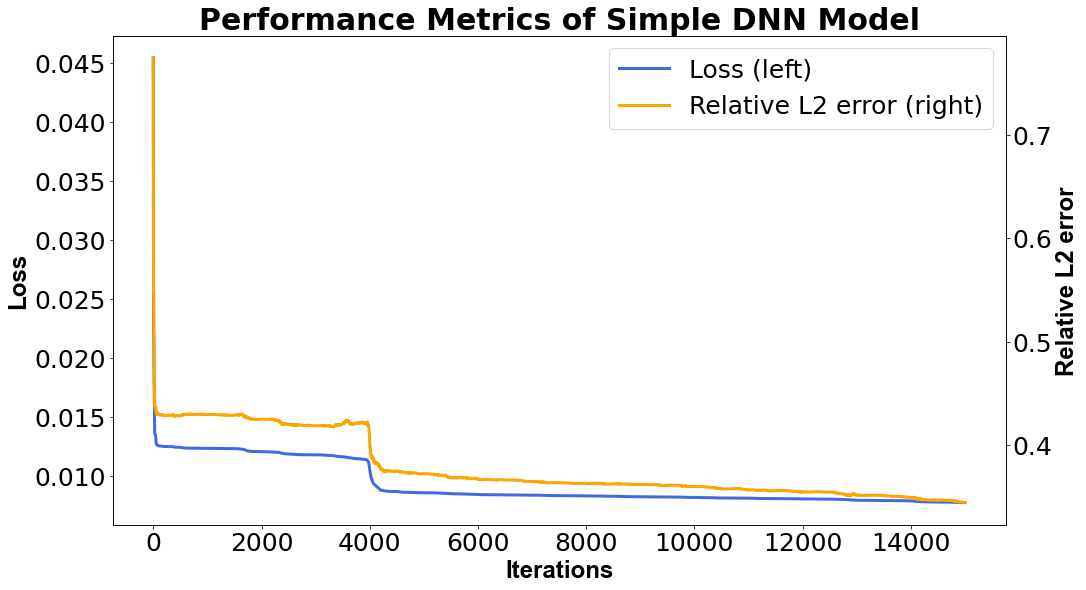

In [17]:
fig, ax1 = plt.subplots()
ax1 = plt.gca() 
ax1.set_facecolor('white')
ax2 = ax1.twinx()
line1 = ax1.plot(loss_record, linewidth = '3', color = "royalblue", label='Loss (left)')
line2 = ax2.plot(l2_record, linewidth = '3', color = "orange", label='Relative L2 error (right)')
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper right')
plt.title("Performance Metrics of Simple DNN Model", fontsize=30, fontweight="bold")
ax1.set_xlabel("Iterations", fontsize=24, fontname = 'Arial', fontweight="bold")
ax1.set_ylabel("Loss", fontsize=24, fontname = 'Arial', fontweight="bold")
ax2.set_ylabel("Relative L2 error", fontsize=24, fontname = 'Arial', fontweight="bold")
fig.set_size_inches(16, 9)

# 전체 그리드 비교

In [18]:
u_pred = PINN.evaluate(X_u_grid)
u_pred = np.reshape(u_pred,usol.shape,order='F')

y_test = usol
y_pred = u_pred

error_vec = np.linalg.norm((y_test-y_pred),2)/np.linalg.norm(y_test,2)

print('MAE = ', mean_absolute_error(y_test, y_pred))
print('MSE = ', mean_squared_error(y_test, y_pred) )
print('RMSE = ', np.sqrt(mean_squared_error(y_test, y_pred)))
print('L2 relative error =', error_vec)
print('--------------------------------------------------')

MAE =  0.6880370359264601
MSE =  31.483326654482454
RMSE =  5.611000503874728
L2 relative error = 56.48788778586858
--------------------------------------------------


Text(0, 0.5, 'Remaining Trip Distance (x 1 mile)')

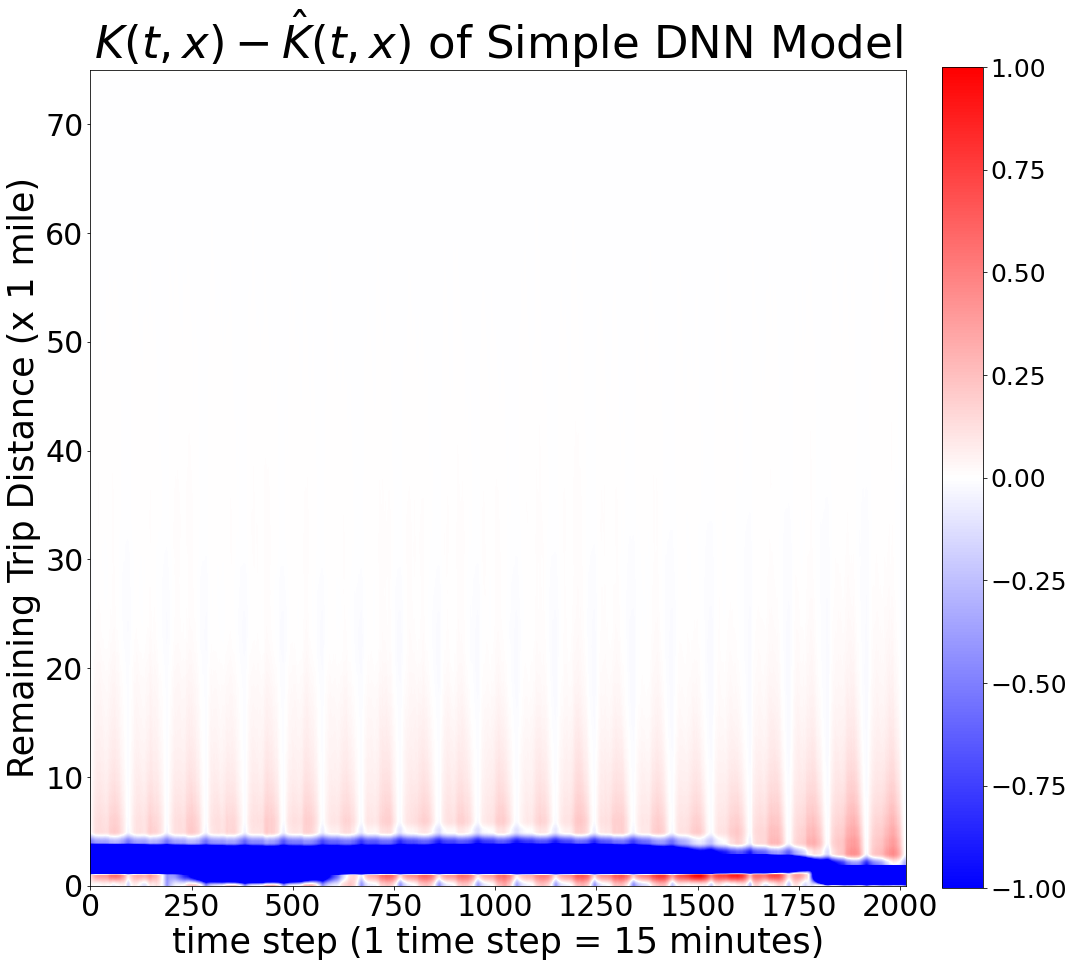

In [ ]:
K_array = np.array(u_pred)
K_array = (usol - K_array)

fig, ax = plt.subplots(figsize=(16, 16))
plt.rcParams['font.size'] = '25'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(30)
plt.imshow(K_array.transpose().T, cmap = 'bwr')
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis([0,2016,0,75])
plt.clim(-1, 1) 
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.title(r'$K(t,x)- \hat{K}(t,x)$' ' of Simple DNN Model', fontsize=45)
plt.xlabel('time step (1 time step = 15 minutes)', fontsize=35)
plt.ylabel('Remaining Trip Distance (x 1 mile)', fontsize=35)

In [ ]:
fig, ax1 = plt.subplots()
ax1 = plt.gca() 
ax1.set_facecolor('white')
ax1.plot(K_array.flatten(), linewidth = '1', color = "royalblue", label='Loss (left)')
plt.title("Observed data - Estimated data(w/ Physics)", fontsize=30, fontweight="bold")
ax1.set_xlabel("Data", fontsize=24, fontname = 'Arial', fontweight="bold")
ax1.set_ylabel("Observed data - Estimated data", fontsize=24, fontname = 'Arial', fontweight="bold")

fig.set_size_inches(16, 9)

Text(0, 0.5, 'Remaining Trip Distance (x 1 mile)')

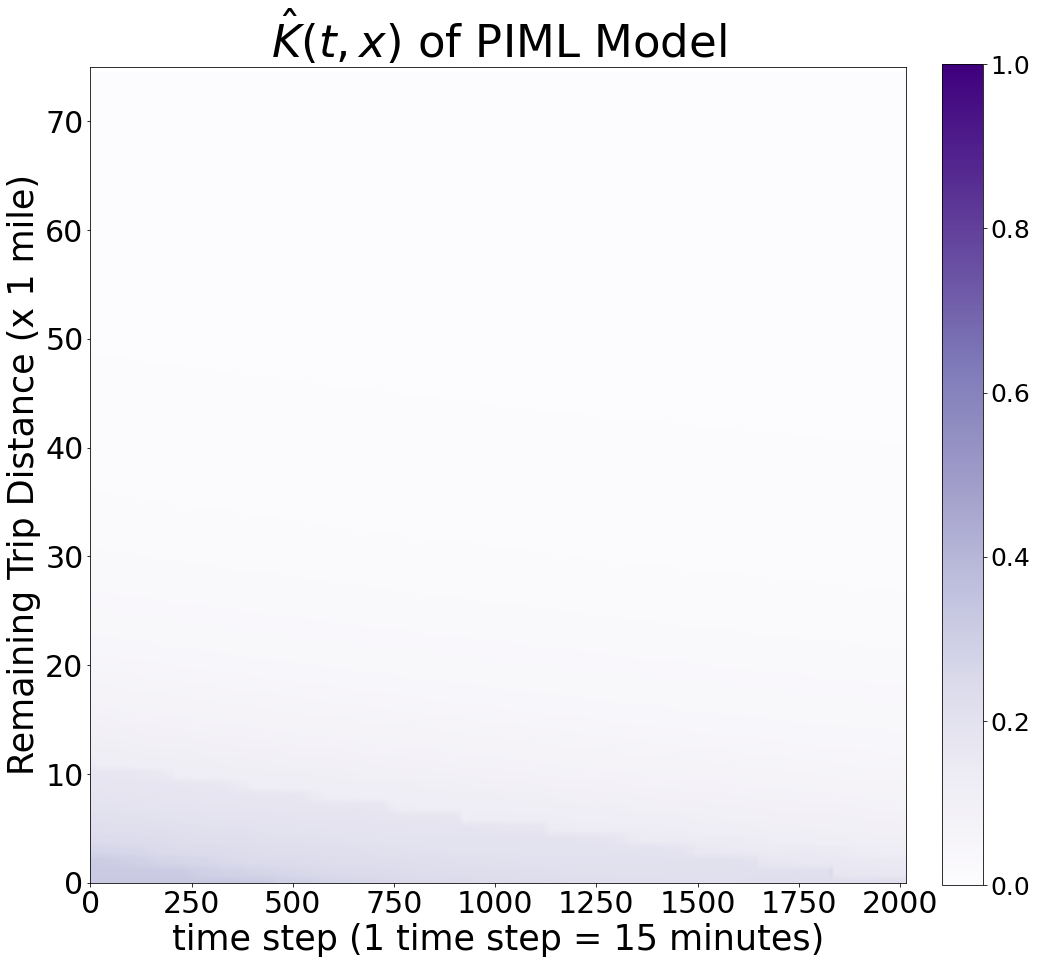

In [32]:
K_array = np.array(u_pred)

fig, ax = plt.subplots(figsize=(16, 16))
plt.rcParams['font.size'] = '25'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(30)
plt.imshow(K_array.transpose().T, cmap = 'Purples')
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis([0,2016,0,75])
plt.clim(0, 1) 
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.title(r'$\hat{K}(t,x)$' ' of PIML Model', fontsize=45)
plt.xlabel('time step (1 time step = 15 minutes)', fontsize=35)
plt.ylabel('Remaining Trip Distance (x 1 mile)', fontsize=35)

Text(0, 0.5, 'Remaining Trip Distance (x 1 mile)')

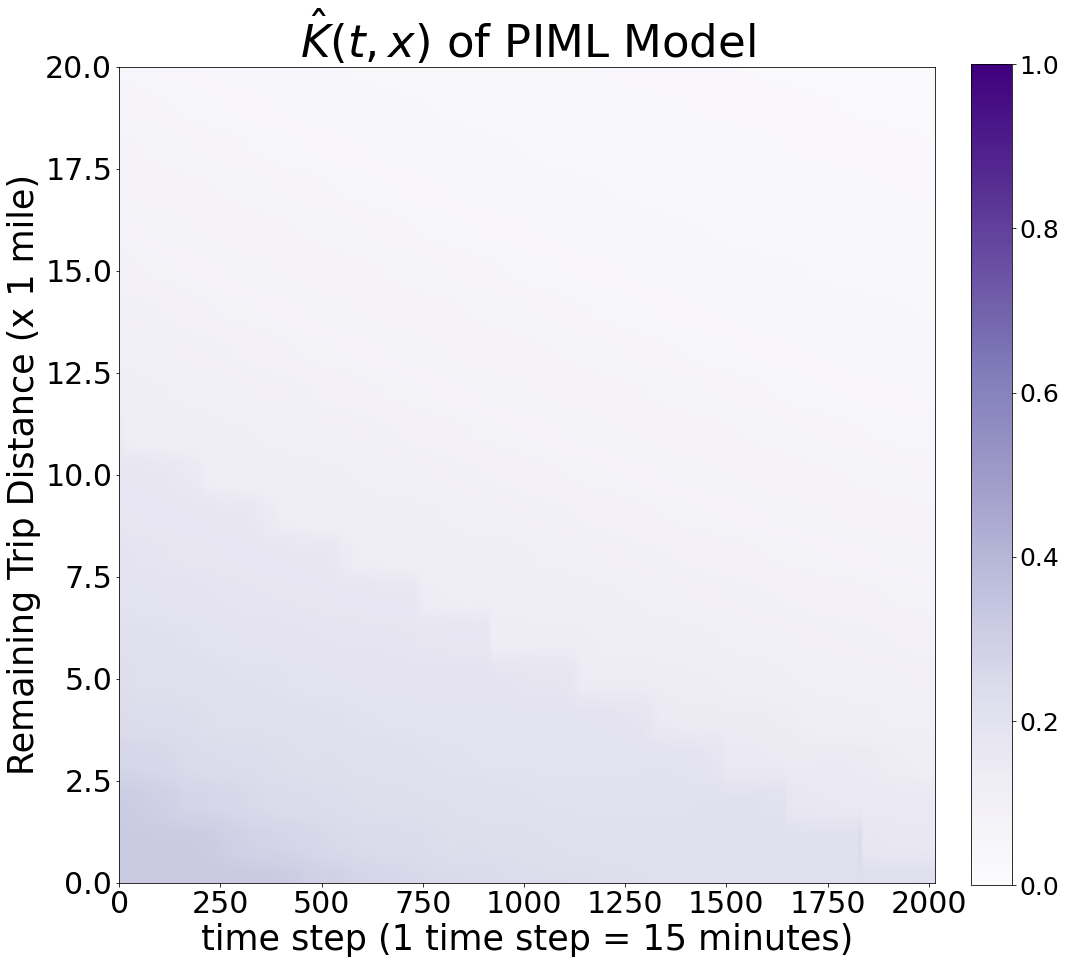

In [33]:
K_array = np.array(u_pred)

fig, ax = plt.subplots(figsize=(16, 16))
plt.rcParams['font.size'] = '25'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(30)
plt.imshow(K_array.transpose().T, cmap = 'Purples')
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis([0,2016,0,20])
plt.clim(0, 1) 
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.title(r'$\hat{K}(t,x)$' ' of PIML Model', fontsize=45)
plt.xlabel('time step (1 time step = 15 minutes)', fontsize=35)
plt.ylabel('Remaining Trip Distance (x 1 mile)', fontsize=35)

Text(0, 0.5, 'Remaining Trip Distance (x 1 mile)')

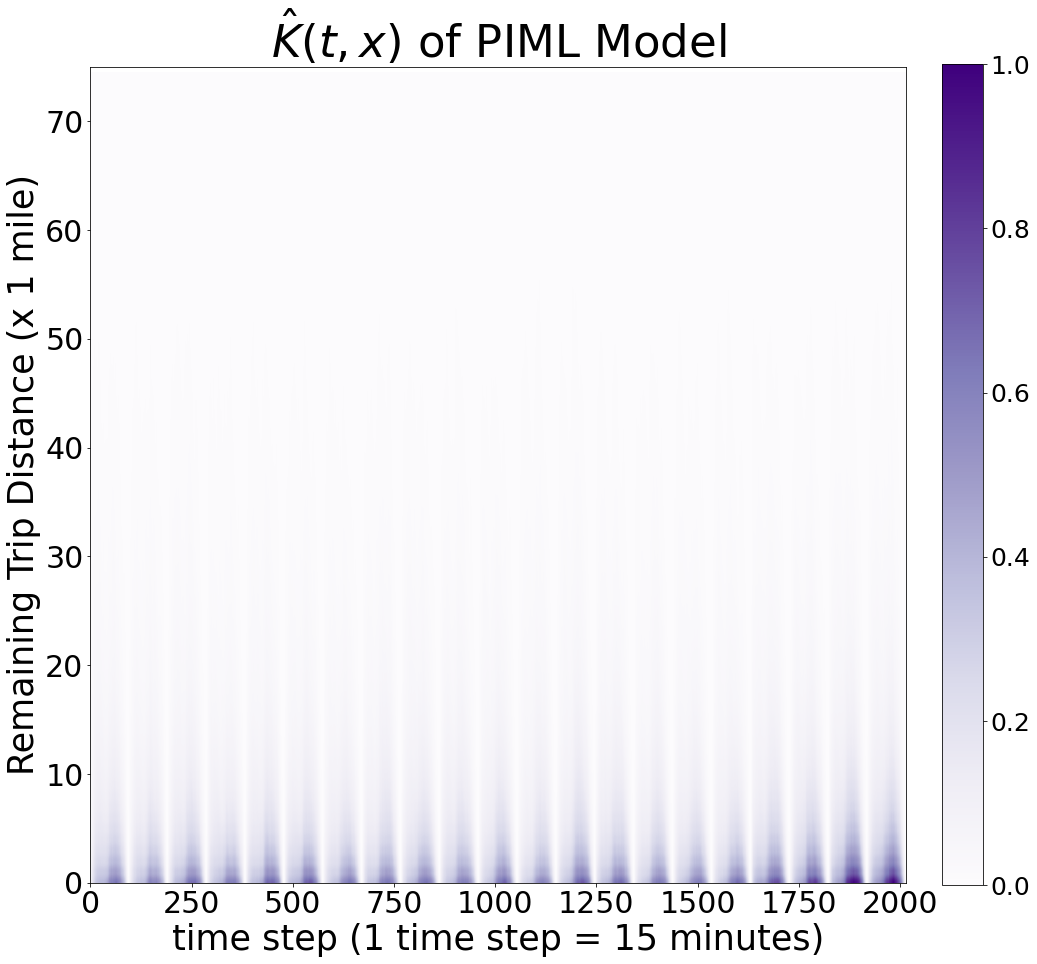

In [34]:
K_array = usol

fig, ax = plt.subplots(figsize=(16, 16))
plt.rcParams['font.size'] = '25'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(30)
plt.imshow(K_array.transpose().T, cmap = 'Purples')
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis([0,2016,0,75])
plt.clim(0, 1) 
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.title(r'$\hat{K}(t,x)$' ' of PIML Model', fontsize=45)
plt.xlabel('time step (1 time step = 15 minutes)', fontsize=35)
plt.ylabel('Remaining Trip Distance (x 1 mile)', fontsize=35)

Text(0, 0.5, 'Remaining Trip Distance (x 1 mile)')

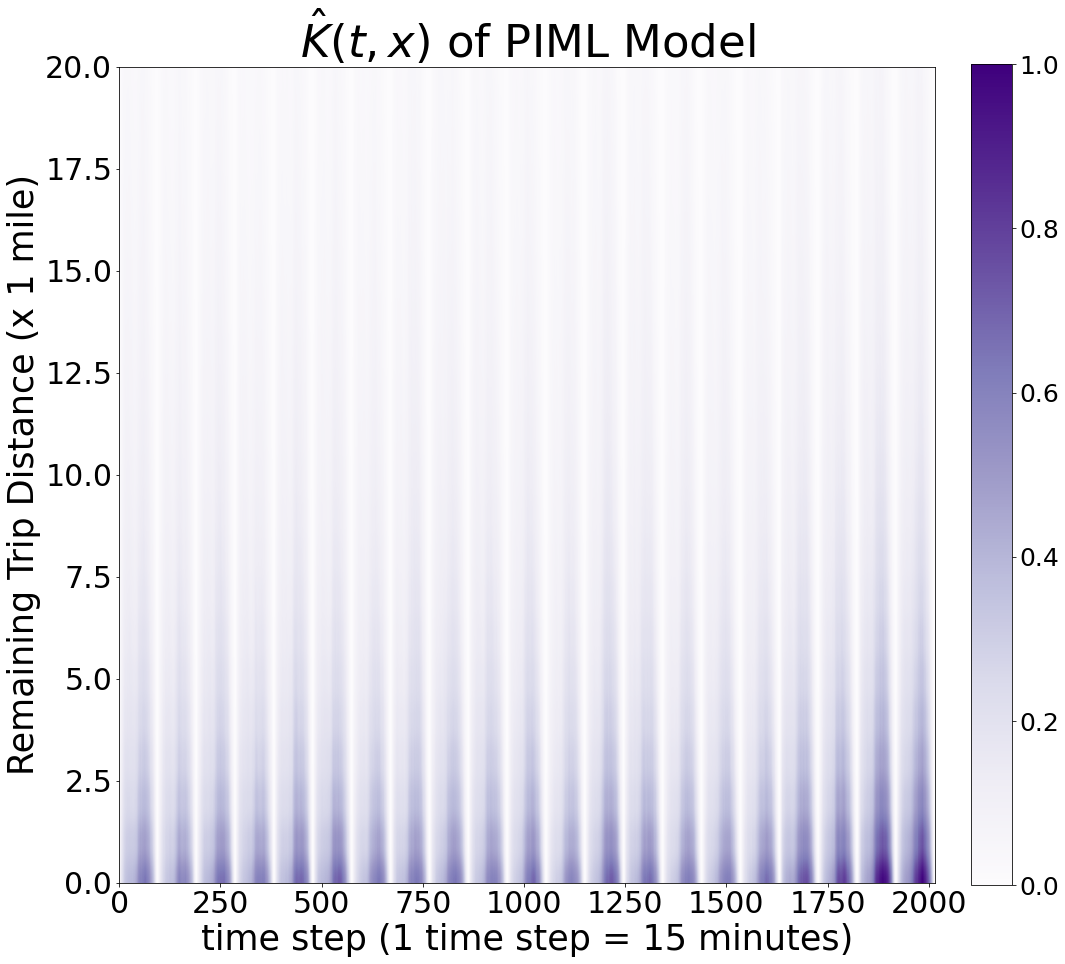

In [35]:
K_array = usol

fig, ax = plt.subplots(figsize=(16, 16))
plt.rcParams['font.size'] = '25'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(30)
plt.imshow(K_array.transpose().T, cmap = 'Purples')
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis([0,2016,0,20])
plt.clim(0, 1) 
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.title(r'$\hat{K}(t,x)$' ' of PIML Model', fontsize=45)
plt.xlabel('time step (1 time step = 15 minutes)', fontsize=35)
plt.ylabel('Remaining Trip Distance (x 1 mile)', fontsize=35)

Text(0, 0.5, 'Remaining Trip Distance (x 1 mile)')

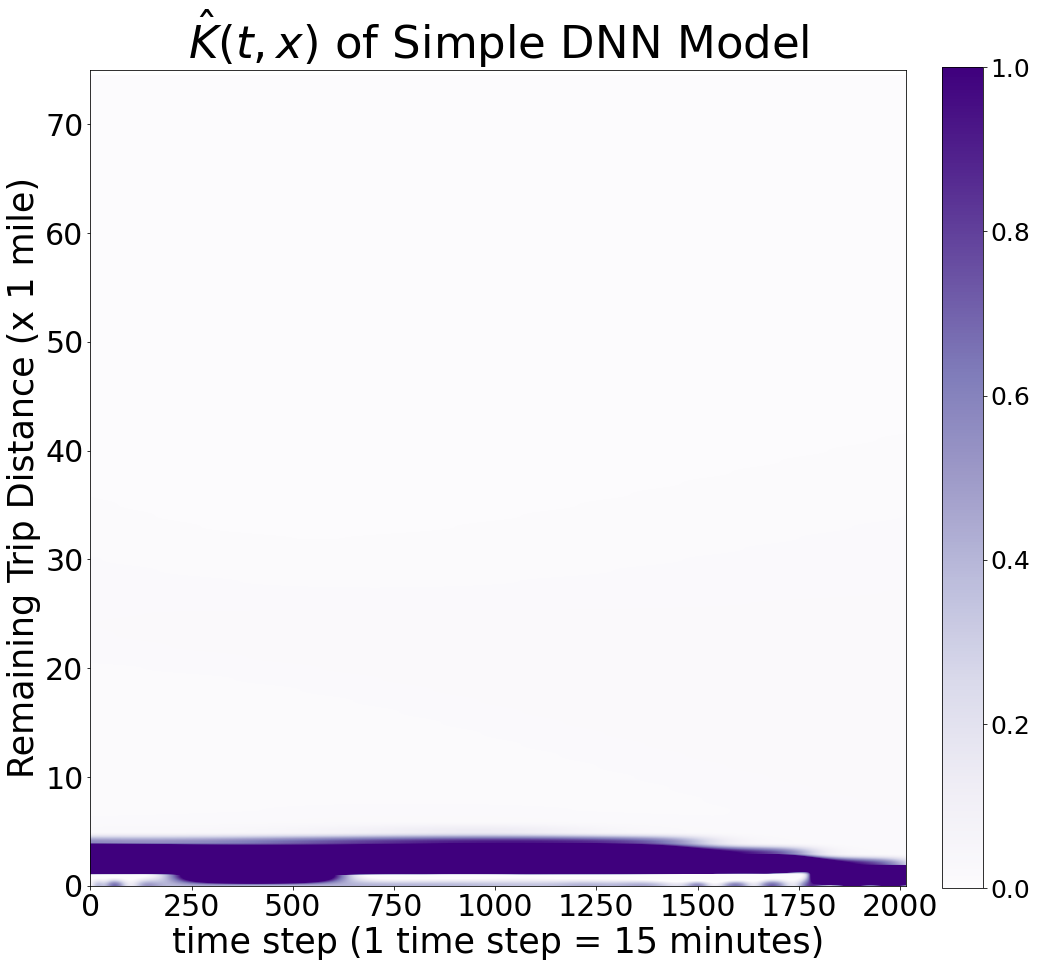

In [21]:
K_array = np.array(u_pred)

fig, ax = plt.subplots(figsize=(16, 16))
plt.rcParams['font.size'] = '25'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(30)
plt.imshow(K_array.transpose().T, cmap = 'Purples')
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis([0,2016,0,75])
plt.clim(0, 1) 
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.title(r'$\hat{K}(t,x)$' ' of Simple DNN Model', fontsize=45)
plt.xlabel('time step (1 time step = 15 minutes)', fontsize=35)
plt.ylabel('Remaining Trip Distance (x 1 mile)', fontsize=35)

Text(0, 0.5, 'Remaining Trip Distance (x 1 mile)')

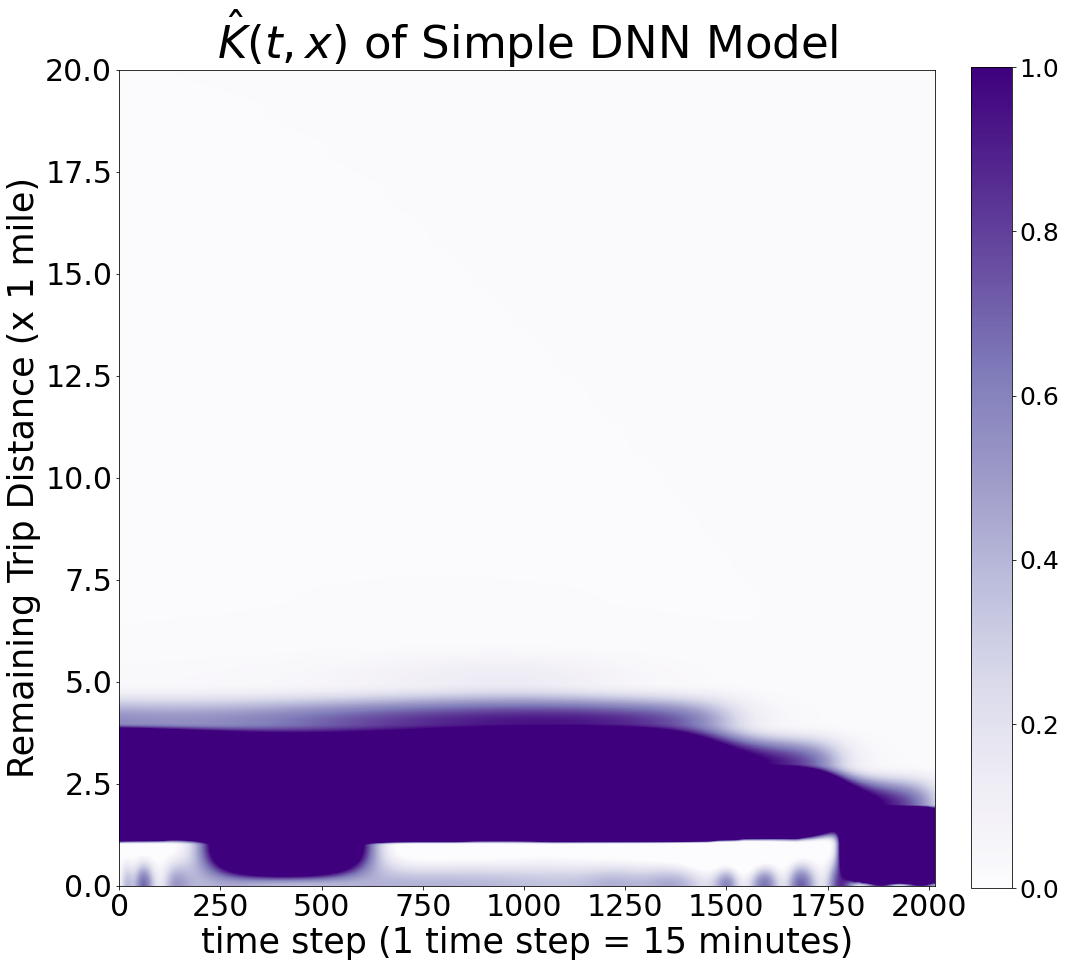

In [22]:
K_array = np.array(u_pred)

fig, ax = plt.subplots(figsize=(16, 16))
plt.rcParams['font.size'] = '25'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(30)
plt.imshow(K_array.transpose().T, cmap = 'Purples')
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis([0,2016,0,20])
plt.clim(0, 1) 
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.title(r'$\hat{K}(t,x)$' ' of Simple DNN Model', fontsize=45)
plt.xlabel('time step (1 time step = 15 minutes)', fontsize=35)
plt.ylabel('Remaining Trip Distance (x 1 mile)', fontsize=35)

Text(0, 0.5, 'Remaining Trip Distance (x 1 mile)')

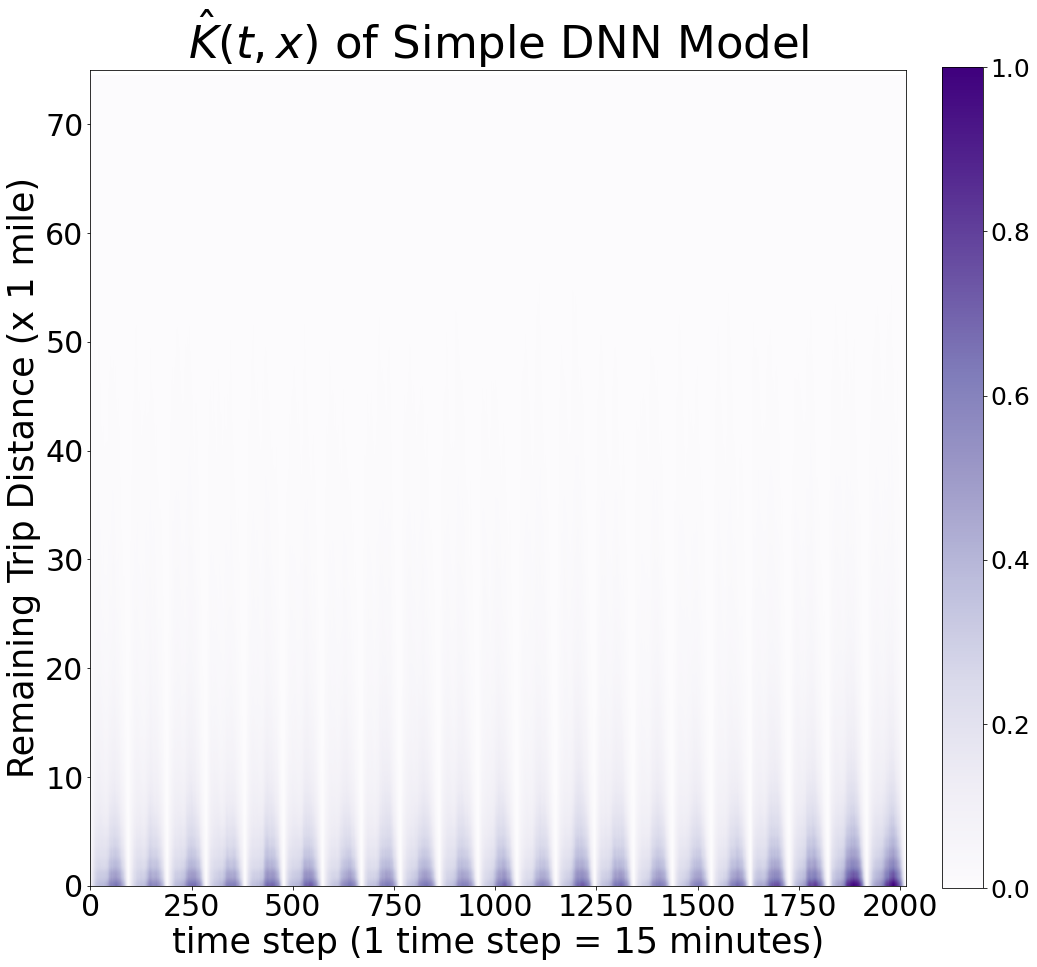

In [23]:
K_array = usol

fig, ax = plt.subplots(figsize=(16, 16))
plt.rcParams['font.size'] = '25'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(30)
plt.imshow(K_array.transpose().T, cmap = 'Purples')
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis([0,2016,0,75])
plt.clim(0, 1) 
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.title(r'$\hat{K}(t,x)$' ' of Simple DNN Model', fontsize=45)
plt.xlabel('time step (1 time step = 15 minutes)', fontsize=35)
plt.ylabel('Remaining Trip Distance (x 1 mile)', fontsize=35)

In [ ]:
K_array = usol

fig, ax = plt.subplots(figsize=(16, 16))
plt.rcParams['font.size'] = '25'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(30)
plt.imshow(K_array.transpose().T, cmap = 'Purples')
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis([0,2016,0,20])
plt.clim(0, 1) 
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.title(r'$\hat{K}(t,x)$' ' of Simple DNN Model', fontsize=45)
plt.xlabel('time step (1 time step = 15 minutes)', fontsize=35)
plt.ylabel('Remaining Trip Distance (x 1 mile)', fontsize=35)